In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
%pip install -q decorator==5.0.9
!pip install -q ipywidgets

import re
import imp
import json
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns
from collections import Counter

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

Note: you may need to restart the kernel to use updated packages.


In [3]:
%pip install -q cltk==1.0.22

Note: you may need to restart the kernel to use updated packages.


In [241]:
# importing local modules

import sys
sys.path.append('../src/')

import text_cleanup.text_cleanup as thesisCleanUp
import preprocessing.text_preprocessing as thesisTextPreprocessing
import data.reader as thesisDataReader
import utils.utils as thesisUtils
import features.tf_idf.n_gram as thesisTfIdfNgramFeatures
import features.count_vectorizer.n_gram as thesisCountVectorizerNgramFeatures
import similarities.cosine as thesisCosineSimilarities
import vocabulary.vocabulary as thesisVocabulary
import features.lexical as thesisLexicalFeatures
import similarities.cosine as thesisCosineSimilarity
import text_cleanup.text_cleanup as thesisTextCleanUp
import p_aligment.p_aligment as thesisPAligment

imp.reload(thesisLexicalFeatures)
imp.reload(thesisCosineSimilarity)
imp.reload(thesisCleanUp)
imp.reload(thesisTextPreprocessing)
imp.reload(thesisDataReader)
imp.reload(thesisUtils)
imp.reload(thesisTfIdfNgramFeatures)
imp.reload(thesisVocabulary)
imp.reload(thesisCosineSimilarities)
imp.reload(thesisTextCleanUp)
imp.reload(thesisCountVectorizerNgramFeatures)
imp.reload(thesisPAligment)

<module 'p_aligment.p_aligment' from '../src/p_aligment/p_aligment.py'>

# p aligment without most similar above by threshold

#### load data

In [5]:
SIMILARITY_SCORE_UPPER_THRESHOLD = 0.8

N_GRAM_RANGE_FOR_SHARED_VOCABULARY_FROM = 36
N_GRAM_RANGE_FOR_SHARED_VOCABULARY_TO = 29

BIDIRECTIONAL_SIMILARITY_THRESHOLD = 0.5

In [6]:
LONDON_INDEXES_TO_REMOVE_SET = set()
ZWICKAU_INDEXES_TO_REMOVE_SET = set()

In [7]:
# london_zwickau_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     thesisDataReader.get_london_by_new_line(),
#     thesisDataReader.get_zwickau_by_new_line(),
# )
# with open('../computed_data/similarities/cross_version/best_similarities/by_new_line/london_zwickau.json', 'w') as f:
#     json.dump(london_zwickau_original_best_similarities, f)

In [8]:
input_file = open('../computed_data/similarities/cross_version/best_similarities/by_new_line/london_zwickau.json')
london_zwickau_original_best_similarities = json.load(input_file)

In [9]:
# zwickau_london_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     thesisDataReader.get_zwickau_by_new_line(),
#     thesisDataReader.get_london_by_new_line(),
# )
# with open('../computed_data/similarities/cross_version/best_similarities/by_new_line/zwickau_london.json', 'w') as f:
#     json.dump(zwickau_london_original_best_similarities, f)

In [10]:
input_file = open('../computed_data/similarities/cross_version/best_similarities/by_new_line/zwickau_london.json')
zwickau_london_original_best_similarities = json.load(input_file)

In [11]:
# london_breslau_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     thesisDataReader.get_london_by_new_line(),
#     thesisDataReader.get_breslau_by_new_line(),
# )
# with open('../computed_data/similarities/cross_version/best_similarities/by_new_line/london_breslau.json', 'w') as f:
#     json.dump(london_breslau_original_best_similarities, f)

In [12]:
input_file = open('../computed_data/similarities/cross_version/best_similarities/by_new_line/london_breslau.json')
london_breslau_original_best_similarities = json.load(input_file)

In [13]:
# zwickau_breslau_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     thesisDataReader.get_zwickau_by_new_line(),
#     thesisDataReader.get_breslau_by_new_line(),
# )
# with open('../computed_data/similarities/cross_version/best_similarities/by_new_line/zwickau_breslau.json', 'w') as f:
#     json.dump(london_breslau_original_best_similarities, f)

In [14]:
input_file = open('../computed_data/similarities/cross_version/best_similarities/by_new_line/zwickau_breslau.json')
zwickau_breslau_original_best_similarities = json.load(input_file)

#### original data

In [15]:
def plot_original_similarities():
    fig, ax = plt.subplots(figsize=(35, 5))

    ax.plot([i['5_gram'][1] for i in london_zwickau_original_best_similarities], label="london_zwickau original")
    ax.plot([i['5_gram'][1] for i in zwickau_london_original_best_similarities], label="zwickau_london original")

    ax.set_ylim([0,1])
    ax.set_xlim([-5,325])
    ax.legend()
    plt.title('Max cross similarity per p')
    plt.show()

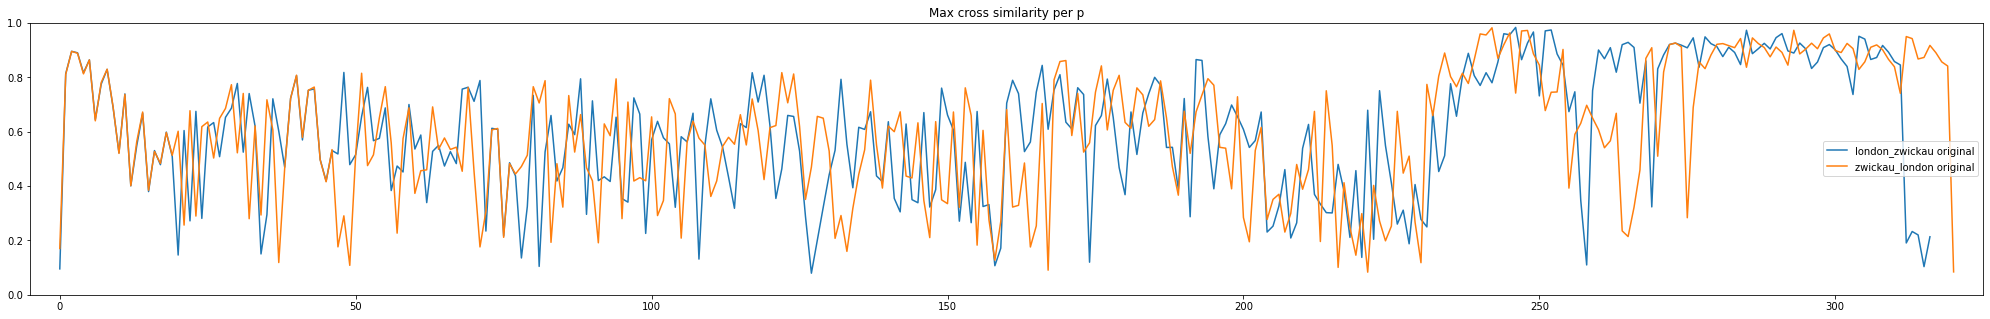

In [16]:
plot_original_similarities()

In [17]:
def create_best_match_by_text_map(
    original_corpus, 
    original_best_similarites, 
    without_strong_similar_corpus, 
    without_strong_similar_best_match
):
    best_match_by_text_map = {}
    
    for p_index, text in enumerate(original_corpus):
        best_match_by_text_map[text] = {
            'original': {
                'index': p_index,
                'best_match': original_best_similarites[p_index]
            }
        }
    
    for p_index, text in enumerate(without_strong_similar_corpus):
                best_match_by_text_map[text] = {
                    **best_match_by_text_map[text],
                    'without_strong_similar': {
                        'index': p_index,
                        'best_match': without_strong_similar_best_match[p_index]
                    }
                }
    
    return best_match_by_text_map

In [18]:
def create_similarities_with_mock_for_drop(original_corpus, best_match_by_p_map):
    mock = []
    for index, text in enumerate(original_corpus):
        text_info = best_match_by_p_map[text]
        similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
        mock.append(similarity_score)

    return mock

#### remove p by threshold and same index

In [19]:
def find_candidate_p_to_remove_by_score_or_index(original_best_similarities):
    p_to_remove = []
    
    for i, s in enumerate(original_best_similarities):
        if s['5_gram'][1] > SIMILARITY_SCORE_UPPER_THRESHOLD: #or s['5_gram'][0] == i:
            p_to_remove.append(i)
    
    return p_to_remove

In [20]:
def remove_p_by_indexes(corpus, indexes_to_remove):
    return [p for i, p in enumerate(corpus) if i not in indexes_to_remove]

In [21]:
london_zwickau_p_to_remove_by_score_or_index = find_candidate_p_to_remove_by_score_or_index(london_zwickau_original_best_similarities)
LONDON_INDEXES_TO_REMOVE_SET = LONDON_INDEXES_TO_REMOVE_SET.union(set(london_zwickau_p_to_remove_by_score_or_index))
len(london_zwickau_p_to_remove_by_score_or_index)

79

In [22]:
zwickau_london_p_to_remove_by_score_or_index = find_candidate_p_to_remove_by_score_or_index(zwickau_london_original_best_similarities)
ZWICKAU_INDEXES_TO_REMOVE_SET = ZWICKAU_INDEXES_TO_REMOVE_SET.union(set(zwickau_london_p_to_remove_by_score_or_index))
len(zwickau_london_p_to_remove_by_score_or_index)

78

In [23]:
for i in london_zwickau_p_to_remove_by_score_or_index:
    london_zwickau_best_match = london_zwickau_original_best_similarities[i]['5_gram']
    zwickau_p = london_zwickau_best_match[0]

    related_zwickau = zwickau_london_original_best_similarities[zwickau_p]
    if london_zwickau_best_match[0] not in zwickau_london_p_to_remove_by_score_or_index:
        print(f'found london {i} without zwickau: {london_zwickau_original_best_similarities[i]}')
        print(f'related zwickau is: {related_zwickau}')

found london 185 without zwickau: {'5_gram': [194, 0.8002479175280295]}
related zwickau is: {'5_gram': [185, 0.7951333425433547]}


In [24]:
london_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_london_by_new_line(), list(LONDON_INDEXES_TO_REMOVE_SET))
zwickau_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_zwickau_by_new_line(), list(ZWICKAU_INDEXES_TO_REMOVE_SET))

In [25]:
print(len(thesisDataReader.get_london_by_new_line()))
print(len(london_corpus_without_strong_similar))

317
238


In [26]:
print(len(thesisDataReader.get_zwickau_by_new_line()))
print(len(zwickau_corpus_without_strong_similar))

321
243


In [27]:
london_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_london_by_new_line(),
    create_best_match_by_text_map(
        thesisDataReader.get_london_by_new_line(),
        london_zwickau_original_best_similarities,
        london_corpus_without_strong_similar,
        thesisCosineSimilarities.get_cross_version_best_similarities(
            london_corpus_without_strong_similar,
            zwickau_corpus_without_strong_similar,
        )
    )
)
london_mock

[0.10162529476823959,
 0,
 0,
 0,
 0,
 0,
 0.6495197482057486,
 0.7765500482648378,
 0,
 0.6901635584450138,
 0.5170483422451865,
 0.7373798957036025,
 0.3897457312199206,
 0.5518204834126579,
 0.6709304031097953,
 0.37095344979003697,
 0.5255834264113418,
 0.4730279338020096,
 0.6002229360883325,
 0.5064841460185077,
 0.14765510835775095,
 0.6082972189164417,
 0.2716141994860789,
 0.6762608505969648,
 0.27764587287549947,
 0.6186139099192995,
 0.6317747044892719,
 0.5088368328982105,
 0.6498221409275923,
 0.6874422795626794,
 0.7752057146031686,
 0.523478869928985,
 0.7391120112125527,
 0.619585811352586,
 0.14947479494447685,
 0.2905499950020424,
 0.7185655813308307,
 0.6065840785385408,
 0.46447412725998327,
 0.7244267764688497,
 0,
 0.5811023378854901,
 0.7555162634233727,
 0.7554665547213757,
 0.4990879194209986,
 0.41863519203750454,
 0.529290492296691,
 0.5274867257917808,
 0,
 0.47450586332290823,
 0.5172463759473749,
 0.6532243558616441,
 0.762089863079629,
 0.5598176384004608

In [28]:
zwickau_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_zwickau_by_new_line(),
    create_best_match_by_text_map(
        thesisDataReader.get_zwickau_by_new_line(),
        zwickau_london_original_best_similarities,
        zwickau_corpus_without_strong_similar,
        thesisCosineSimilarities.get_cross_version_best_similarities(
            zwickau_corpus_without_strong_similar,
            london_corpus_without_strong_similar,
        )
    )
)
zwickau_mock

[0.18097751009955515,
 0,
 0,
 0,
 0,
 0,
 0.6429155625224025,
 0.7816957021398797,
 0,
 0.6930422346191365,
 0.515490762440388,
 0.7354137932522266,
 0.3914089151971908,
 0.5707774998598638,
 0.6774644871354537,
 0.378451699266387,
 0.5246212169671293,
 0.47912923598762863,
 0.598106523704139,
 0.5136897161149262,
 0.6045585186312523,
 0.2504220201413765,
 0.6791936121474663,
 0.286197476577909,
 0.6205987004765143,
 0.6334273616106927,
 0.5040140228879921,
 0.6453764330932208,
 0.6854147450264604,
 0.7704835720858457,
 0.5205518310651297,
 0.7382566822826261,
 0.2775447679718108,
 0.6208213645278493,
 0.2941035029085212,
 0.7150913523329202,
 0.6106155839142167,
 0.12228396289197972,
 0.45883814188128047,
 0.724693086939356,
 0,
 0.5895326747605354,
 0.7546833643361678,
 0.7623661965248865,
 0.4970055333941739,
 0.41416205471890466,
 0.5304953532799556,
 0.1735592109193082,
 0.24123897566645963,
 0.10582461865317348,
 0.520673551001459,
 0,
 0.47089491644660025,
 0.5175278452296681,


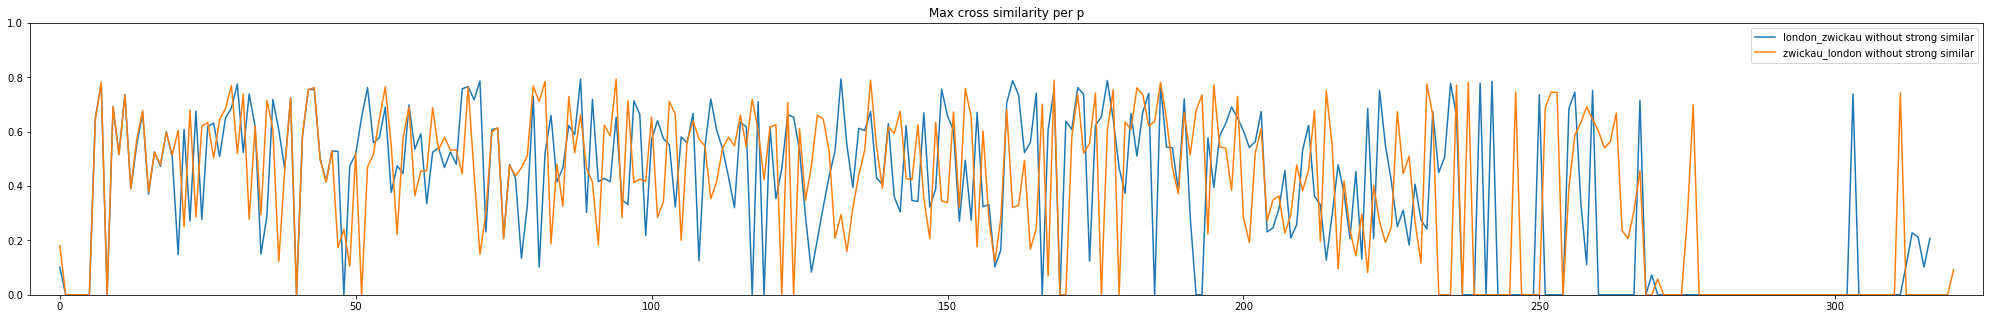

In [29]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot(zwickau_mock, label="zwickau_london without strong similar")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

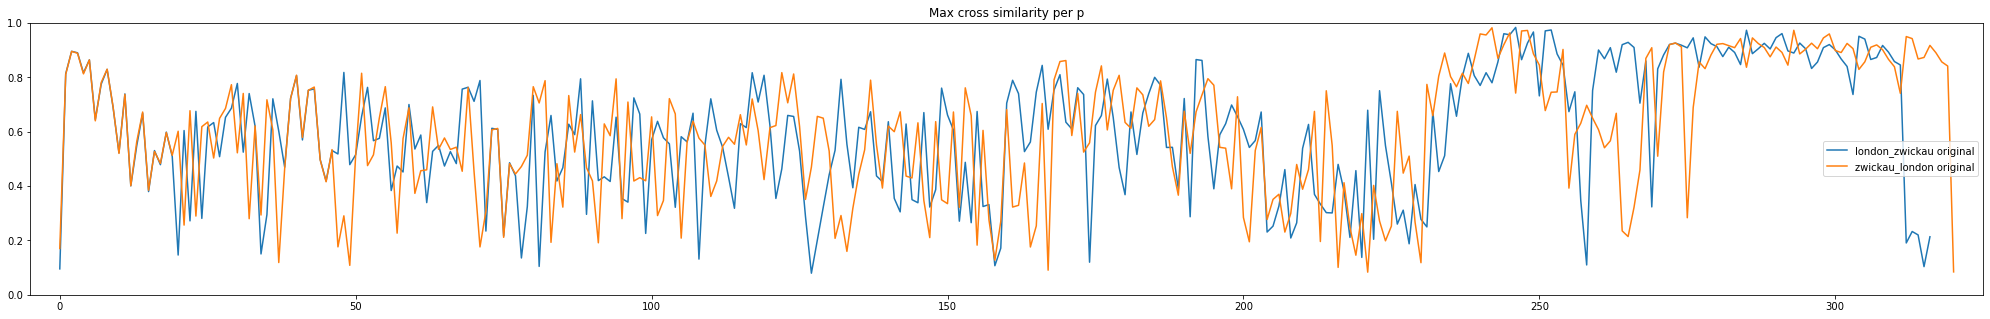

In [30]:
plot_original_similarities()

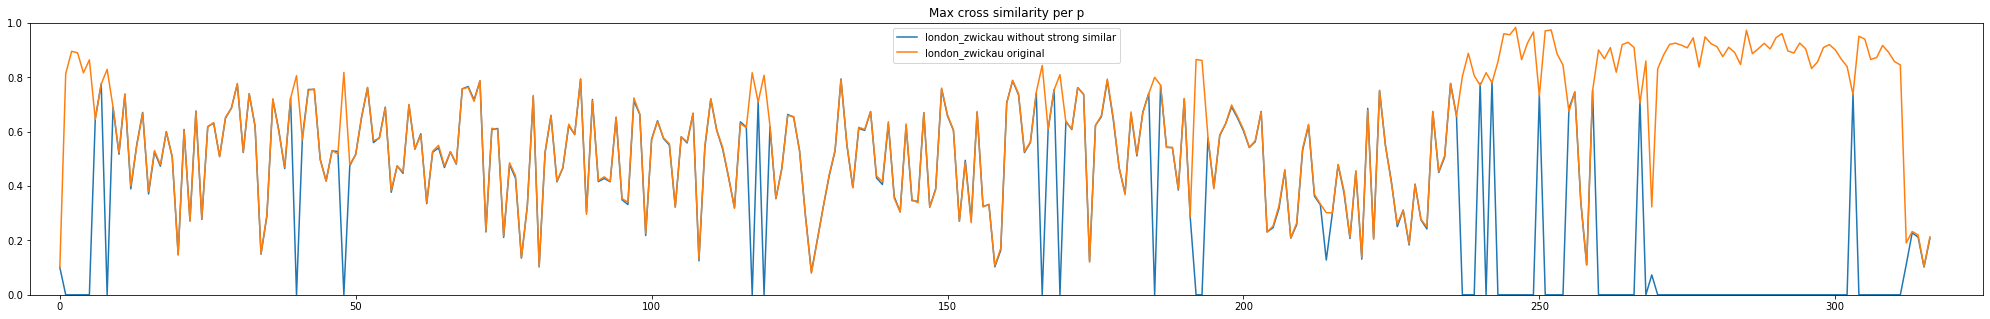

In [31]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot([i['5_gram'][1] for i in london_zwickau_original_best_similarities], label="london_zwickau original")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

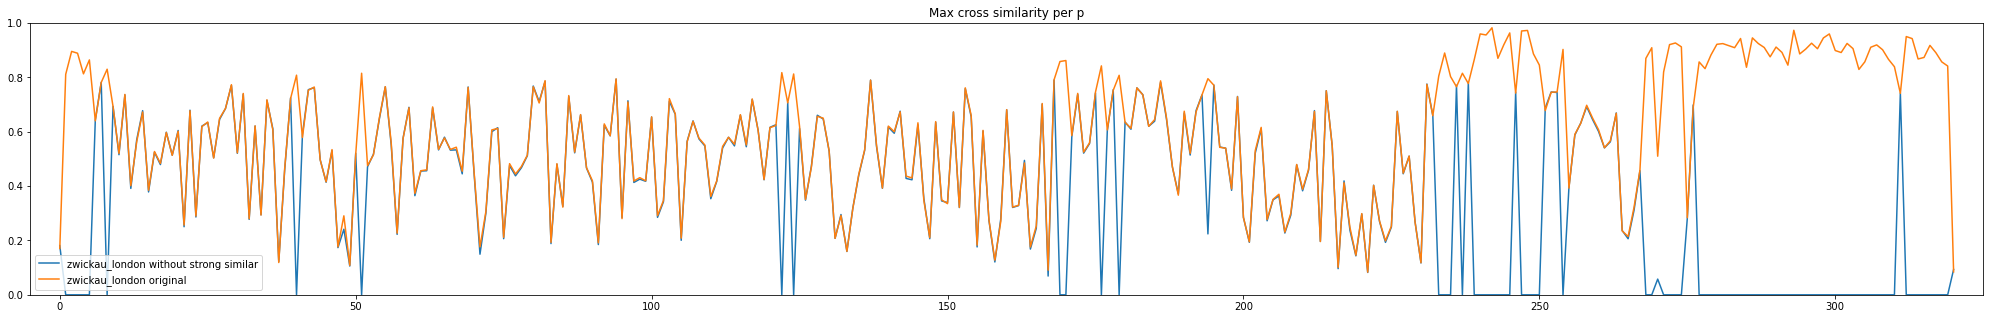

In [32]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(zwickau_mock, label="zwickau_london without strong similar")
ax.plot([i['5_gram'][1] for i in zwickau_london_original_best_similarities], label="zwickau_london original")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

#### remove by shared ngrm

In [33]:
for n_gram_range in range(N_GRAM_RANGE_FOR_SHARED_VOCABULARY_FROM, N_GRAM_RANGE_FOR_SHARED_VOCABULARY_TO, -1):
    shared_words = thesisVocabulary.get_version_shared_words(
        thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
            zwickau_corpus_without_strong_similar, 
            n_gram_range, 
            n_gram_range
        ),
        'zwickau',
        thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
            london_corpus_without_strong_similar, 
            n_gram_range, 
            n_gram_range
        ),
        'london',
        thesisCountVectorizerNgramFeatures.get_ngrams_words_dictionary(
            thesisDataReader.get_breslau_by_new_line(), 
            n_gram_range, 
            n_gram_range
        ),
    )

    london_zwickau_p_to_remove_by_shared_word = []
    zwickau_london_p_to_remove_by_shared_word = []
    
    for shared_word in shared_words:
        london_indexes_for_shared_word = thesisUtils.find_text_p_indexed_in_corpus(london_corpus_without_strong_similar, shared_word)
        london_zwickau_p_to_remove_by_shared_word = london_zwickau_p_to_remove_by_shared_word + london_indexes_for_shared_word
        
        zwickau_indexes_for_shared_word = thesisUtils.find_text_p_indexed_in_corpus(zwickau_corpus_without_strong_similar, shared_word)
        zwickau_london_p_to_remove_by_shared_word = zwickau_london_p_to_remove_by_shared_word + zwickau_indexes_for_shared_word

print('london_zwickau_p_to_remove_by_shared_word', len(london_zwickau_p_to_remove_by_shared_word))
print('zwickau_london_p_to_remove_by_shared_word', len(zwickau_london_p_to_remove_by_shared_word))

print('len LONDON_INDEXES_TO_REMOVE_SET before', len(LONDON_INDEXES_TO_REMOVE_SET))
print('len ZWICKAU_INDEXES_TO_REMOVE_SET before', len(ZWICKAU_INDEXES_TO_REMOVE_SET))

LONDON_INDEXES_TO_REMOVE_SET = LONDON_INDEXES_TO_REMOVE_SET.union(set(london_zwickau_p_to_remove_by_shared_word))
ZWICKAU_INDEXES_TO_REMOVE_SET = ZWICKAU_INDEXES_TO_REMOVE_SET.union(set(zwickau_london_p_to_remove_by_shared_word))

print('len LONDON_INDEXES_TO_REMOVE_SET after', len(LONDON_INDEXES_TO_REMOVE_SET))
print('len ZWICKAU_INDEXES_TO_REMOVE_SET after', len(ZWICKAU_INDEXES_TO_REMOVE_SET))

london_zwickau_p_to_remove_by_shared_word 6
zwickau_london_p_to_remove_by_shared_word 6
len LONDON_INDEXES_TO_REMOVE_SET before 79
len ZWICKAU_INDEXES_TO_REMOVE_SET before 78
len LONDON_INDEXES_TO_REMOVE_SET after 80
len ZWICKAU_INDEXES_TO_REMOVE_SET after 79


In [34]:
print(LONDON_INDEXES_TO_REMOVE_SET)
print(ZWICKAU_INDEXES_TO_REMOVE_SET)

{1, 2, 3, 4, 5, 260, 261, 8, 262, 263, 264, 265, 266, 268, 270, 271, 272, 273, 274, 275, 276, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 40, 295, 296, 297, 298, 299, 300, 301, 48, 302, 304, 305, 306, 307, 308, 309, 310, 311, 117, 119, 166, 169, 185, 192, 193, 217, 237, 238, 239, 241, 243, 244, 245, 246, 247, 248, 249, 251, 252, 253, 254}
{1, 2, 3, 4, 5, 8, 268, 269, 271, 272, 273, 274, 277, 278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290, 291, 292, 293, 294, 295, 40, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 51, 306, 307, 308, 309, 310, 312, 313, 314, 315, 316, 317, 318, 319, 122, 124, 169, 170, 176, 179, 212, 233, 234, 235, 237, 239, 240, 241, 242, 243, 244, 245, 247, 248, 249, 250, 254}


In [35]:
london_zwickau_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_corpus_without_strong_similar,
    zwickau_corpus_without_strong_similar,
)

In [36]:
zwickau_london_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_corpus_without_strong_similar,
    london_corpus_without_strong_similar,
)

In [37]:
print(london_zwickau_without_strong_similar_best_similarities[217])
print(zwickau_london_without_strong_similar_best_similarities[211])

{'5_gram': (212, 0.6733781124698798)}
{'5_gram': (216, 0.24925556977245988)}


In [38]:
print('lengths before:')
print(len(london_corpus_without_strong_similar))
print(len(zwickau_corpus_without_strong_similar))

london_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_london_by_new_line(), list(LONDON_INDEXES_TO_REMOVE_SET))
zwickau_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_zwickau_by_new_line(), list(ZWICKAU_INDEXES_TO_REMOVE_SET))

print('lengths after:')
print(len(london_corpus_without_strong_similar))
print(len(zwickau_corpus_without_strong_similar))

lengths before:
238
243
lengths after:
237
242


In [39]:
london_zwickau_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_corpus_without_strong_similar,
    zwickau_corpus_without_strong_similar,
)

In [40]:
zwickau_london_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_corpus_without_strong_similar,
    london_corpus_without_strong_similar,
)

In [41]:
# def create_best_match_by_text_map(
#     original_corpus, 
#     original_best_similarites, 
#     without_strong_similar_corpus, 
#     without_strong_similar_best_match
# ):
#     best_match_by_text_map = {}
    
#     for p_index, text in enumerate(original_corpus):
#         best_match_by_text_map[text] = {
#             'original': {
#                 'index': p_index,
#                 'best_match': original_best_similarites[p_index]
#             }
#         }
    
#     for p_index, text in enumerate(without_strong_similar_corpus):
#                 best_match_by_text_map[text] = {
#                     **best_match_by_text_map[text],
#                     'without_strong_similar': {
#                         'index': p_index,
#                         'best_match': without_strong_similar_best_match[p_index]
#                     }
#                 }
    
#     return best_match_by_text_map

In [42]:
london_zwickau_best_match_by_p_map = create_best_match_by_text_map(
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_original_best_similarities,
    london_corpus_without_strong_similar,
    london_zwickau_without_strong_similar_best_similarities,
)

In [43]:
zwickau_london_best_match_by_p_map = create_best_match_by_text_map(
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_original_best_similarities,
    zwickau_corpus_without_strong_similar,
    zwickau_london_without_strong_similar_best_similarities
)

In [44]:
# for p_index, text in enumerate(london_corpus_without_strong_similar):
#     text_data = london_zwickau_best_match_by_p_map[text]

#     original = text_data['original']
#     original_best_match = original['best_match']['5_gram']
#     original_best_match_p = original_best_match[0]
#     original_best_match_score = original_best_match[1]
    
#     without_strong_similar = text_data['without_strong_similar']
#     without_strong_similar_best_match = without_strong_similar['best_match']['5_gram']
#     without_strong_similar_best_match_p = without_strong_similar_best_match[0]
#     without_strong_similar_best_match_score = without_strong_similar_best_match[1]
    
#     zwickau_text_in_original = thesisDataReader.get_zwickau_by_new_line()[original_best_match_p]
#     zwickau_text_in_without_strong_similar = zwickau_corpus_without_strong_similar[without_strong_similar_best_match_p]
    
#     if zwickau_text_in_original != zwickau_text_in_without_strong_similar:
#         was_removed = True if original_best_match_p in zwickau_p_to_remove_set else False
#         print('# found mismatch for:')
#         print(text)
#         print()
#         print(f'original best match with score: {original_best_match_score} was to zwickau p {original_best_match_p}, was remove - {was_removed}:')
#         print(zwickau_text_in_original)
#         print()
#         print(f'new best match with score: {without_strong_similar_best_match_score} to zwickau new p index {without_strong_similar_best_match_p}:')
#         print(zwickau_text_in_without_strong_similar)
#         print()
#         print()
#         print()


#     if original_best_match_score - without_strong_similar_best_match_score > 0.1:
#         print(f'% found score mismatch for:\n{text}\n')
#         print(f'original match score was: {original_best_match_score}, was to zwickau p {original_best_match_p}, was removed - {was_removed}:')
#         print(zwickau_text_in_original)
#         print()
#         print(f'new match score was: {without_strong_similar_best_match_score}, to zwickau new p index {without_strong_similar_best_match_p}:')
#         print(zwickau_text_in_without_strong_similar)
#         print('\n'*3)

In [45]:
# for p_index, text in enumerate(zwickau_corpus_without_strong_similar):
#     text_data = zwickau_london_best_match_by_p_map[text]

#     original = text_data['original']
#     original_best_match = original['best_match']['5_gram']
#     original_best_match_p = original_best_match[0]
#     original_best_match_score = original_best_match[1]
    
#     without_strong_similar = text_data['without_strong_similar']
#     without_strong_similar_best_match = without_strong_similar['best_match']['5_gram']
#     without_strong_similar_best_match_p = without_strong_similar_best_match[0]
#     without_strong_similar_best_match_score = without_strong_similar_best_match[1]
    
#     london_text_in_original = thesisDataReader.get_london_by_new_line()[original_best_match_p]
#     london_text_in_without_strong_similar = london_corpus_without_strong_similar[without_strong_similar_best_match_p]
        
#     if london_text_in_original != london_text_in_without_strong_similar:
#         was_removed = True if original_best_match_p in london_p_to_remove_set else False
#         print('# found text mismatch for:')
#         print(text)
#         print()
#         print(f'original best match with score: {original_best_match_score} was to london p {original_best_match_p}, was removed - {was_removed}:')
#         print(london_text_in_original)
#         print()
#         print(f'new best match with score: {without_strong_similar_best_match_score} to london new p index {without_strong_similar_best_match_p}:')
#         print(london_text_in_without_strong_similar)
#         print('\n'*3)
    
#     if original_best_match_score - without_strong_similar_best_match_score > 0.1:
#         print(f'% found score mismatch for:\n{text}')
#         print(f'original match score was: {original_best_match_score}, was to london p {original_best_match_p}, was removed - {was_removed}:')
#         print(london_text_in_original)
#         print()
#         print(f'new match score was: {without_strong_similar_best_match_score}, to london new p index {without_strong_similar_best_match_p}:')
#         print(london_text_in_without_strong_similar)
#         print('\n'*3)

In [46]:
# london_zwickau_full_remove_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     london_corpus_without_strong_similar,
#     zwickau_corpus_without_strong_similar,
# )

In [47]:
# zwickau_london_full_remove_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     zwickau_corpus_without_strong_similar,
#     london_corpus_without_strong_similar,
# )

In [48]:
# london_mock = []

# for index, text in enumerate(thesisDataReader.get_london_by_new_line()):
#     text_info = london_zwickau_best_match_by_p_map[text]
#     similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
#     london_mock.append(similarity_score)
london_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map,
)
london_mock

[0.1014416748113306,
 0,
 0,
 0,
 0,
 0,
 0.6495786251664826,
 0.7766359659031814,
 0,
 0.6900581048083675,
 0.516842464393126,
 0.7373020407685061,
 0.38976394703995665,
 0.5516646242618751,
 0.6704137674772539,
 0.37081110152383384,
 0.5255285167917078,
 0.4725552811058992,
 0.6003845068800575,
 0.5068054907035842,
 0.14750572782992039,
 0.608392758731031,
 0.2715466076419113,
 0.6761528468536173,
 0.2774794694388618,
 0.6186861840838414,
 0.6318319787562368,
 0.509922518142753,
 0.6498448017261312,
 0.6874196243503288,
 0.7750708409175002,
 0.5235406392941216,
 0.7389809596954153,
 0.6196682910020074,
 0.14936577064945747,
 0.29048124937717873,
 0.7172749393341854,
 0.6070587446492639,
 0.46444437708454406,
 0.7245409209143435,
 0,
 0.5809355515401204,
 0.7553025923800778,
 0.7550685868211284,
 0.4994994540654625,
 0.41833420325318665,
 0.5292589898203598,
 0.5275096403556212,
 0,
 0.474212741671918,
 0.5170674061662008,
 0.6531639049767458,
 0.7620206160174419,
 0.5595788797495809,

In [49]:
zwickau_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map,
)
zwickau_mock

[0.1807873753188014,
 0,
 0,
 0,
 0,
 0,
 0.6428037748762189,
 0.7821009262323146,
 0,
 0.6931064894283661,
 0.5139747568387059,
 0.7351454988711696,
 0.39093010623860297,
 0.570814052547209,
 0.6774641773076981,
 0.37789808631651295,
 0.5246371262731429,
 0.47942242284715814,
 0.5980901525563165,
 0.5135708823450984,
 0.6044528022612242,
 0.2508615400911135,
 0.679192068572065,
 0.28609492416999066,
 0.620400417875358,
 0.6336097323157498,
 0.5046008649816404,
 0.6453784396330328,
 0.6854022951560135,
 0.7705396833391931,
 0.5208720268529902,
 0.7381662782329332,
 0.27716930041618204,
 0.6201905295911969,
 0.29369985570716306,
 0.7150065850053899,
 0.6108118467419938,
 0.12253620213332134,
 0.4589729664883502,
 0.7252599390485136,
 0,
 0.5899871093479139,
 0.7548592941274223,
 0.7621764858835305,
 0.4974580403455979,
 0.41433208489806606,
 0.5303605023821886,
 0.1735842279354999,
 0.24198467673129925,
 0.1058263432794409,
 0.5209200482813027,
 0,
 0.4706737029392322,
 0.51739945382140

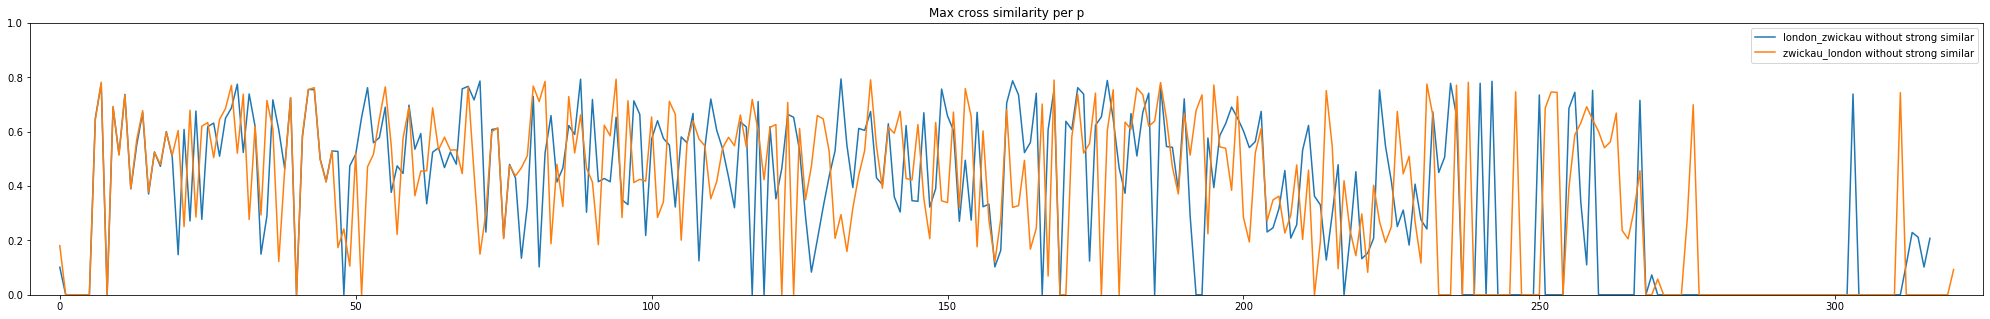

In [50]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot(zwickau_mock, label="zwickau_london without strong similar")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

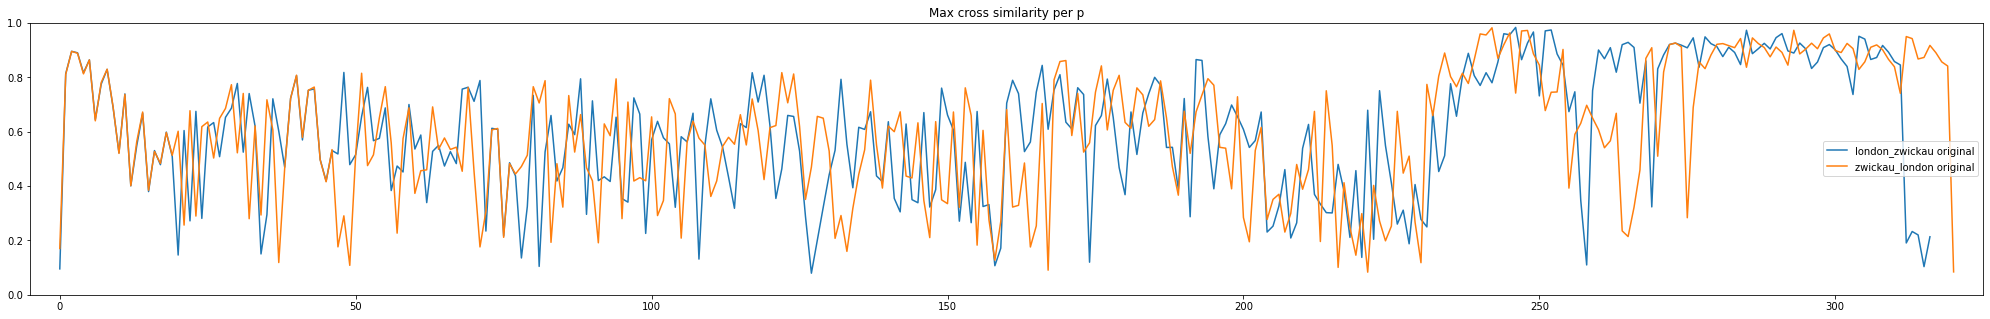

In [51]:
plot_original_similarities()

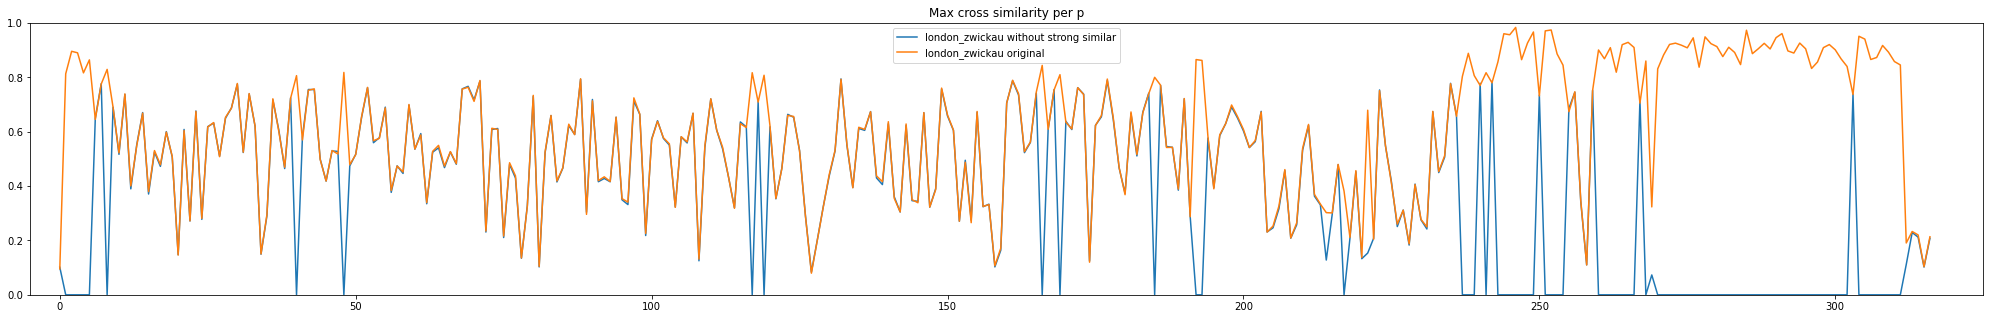

In [52]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot([i['5_gram'][1] for i in london_zwickau_original_best_similarities], label="london_zwickau original")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

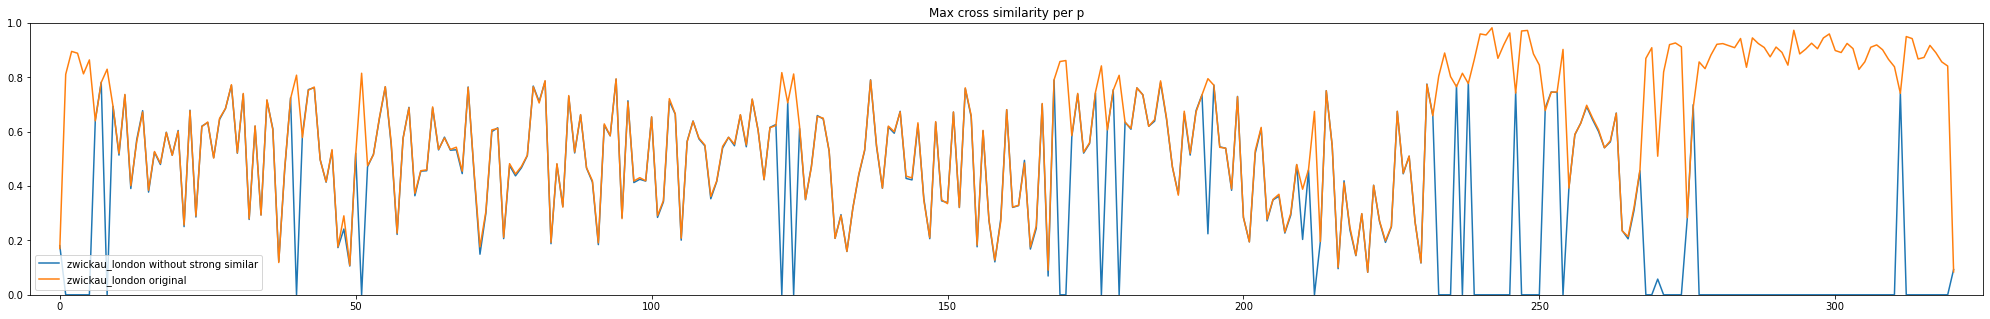

In [53]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(zwickau_mock, label="zwickau_london without strong similar")
ax.plot([i['5_gram'][1] for i in zwickau_london_original_best_similarities], label="zwickau_london original")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

#### remove by bidirectional similarity with score > 0.5

In [54]:
def get_indexes_with_bidirectional_similarity(
    mock_similarities,
    
    version_a_corpus,
    version_a_best_match_by_p_map,

    version_b_corpus,
    version_b_best_match_by_p_map,
):
    result = []
    for i, p in enumerate(mock_similarities):
        if p > 0:
            version_a_p_info = version_a_best_match_by_p_map[version_a_corpus[i]]
            version_a_p_info_original = version_a_p_info['original']
            version_a_p_info_original_best_match_p = version_a_p_info_original['best_match']['5_gram'][0]
#             print(version_a_p_info_original_best_match_p)
            version_a_p_info_original_best_match_score = version_a_p_info_original['best_match']['5_gram'][1]
            
            version_b_p_info = version_b_best_match_by_p_map[version_b_corpus[version_a_p_info_original_best_match_p]]
            version_b_p_info_original = version_b_p_info['original']
            version_b_p_info_original_best_match_p = version_b_p_info_original['best_match']['5_gram'][0]
            version_b_p_info_original_best_match_score = version_b_p_info_original['best_match']['5_gram'][1]
            
            if i == 30:
                print('running on', i)
                print('version_a_p_info', version_a_p_info)
                print('version_b_p_info',version_b_p_info)
                print('version_a_p_info_original_best_match_p', version_a_p_info_original_best_match_p)
                print('version_b_p_info_original_best_match_p', version_b_p_info_original_best_match_p)
                print('version_a_p_info_original_best_match_p == version_b_p_info_original_best_match_p', version_a_p_info_original_best_match_p == version_b_p_info_original_best_match_p)
            
            if i == version_b_p_info_original_best_match_p and (version_a_p_info_original_best_match_score > BIDIRECTIONAL_SIMILARITY_THRESHOLD and version_b_p_info_original_best_match_score > BIDIRECTIONAL_SIMILARITY_THRESHOLD):
                result.append(i)
    
    return result

In [55]:
get_indexes_with_bidirectional_similarity(
    london_mock,
    
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map,
    
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map
)

running on 30
version_a_p_info {'original': {'index': 30, 'best_match': {'5_gram': [29, 0.7774978841416829]}}, 'without_strong_similar': {'index': 24, 'best_match': {'5_gram': (23, 0.7750708409175002)}}}
version_b_p_info {'original': {'index': 29, 'best_match': {'5_gram': [30, 0.7729869556331048]}}, 'without_strong_similar': {'index': 23, 'best_match': {'5_gram': (24, 0.7705396833391931)}}}
version_a_p_info_original_best_match_p 29
version_b_p_info_original_best_match_p 30
version_a_p_info_original_best_match_p == version_b_p_info_original_best_match_p False


[6,
 7,
 9,
 10,
 11,
 13,
 14,
 16,
 18,
 19,
 21,
 23,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 36,
 37,
 39,
 41,
 42,
 43,
 46,
 47,
 50,
 51,
 52,
 53,
 54,
 55,
 59,
 60,
 61,
 63,
 64,
 66,
 68,
 69,
 70,
 71,
 73,
 74,
 80,
 82,
 83,
 86,
 87,
 88,
 90,
 94,
 97,
 98,
 100,
 101,
 102,
 103,
 105,
 106,
 107,
 109,
 110,
 111,
 112,
 115,
 116,
 118,
 120,
 123,
 124,
 125,
 131,
 132,
 133,
 135,
 136,
 137,
 140,
 143,
 146,
 149,
 150,
 151,
 155,
 160,
 161,
 162,
 163,
 164,
 165,
 167,
 168,
 170,
 171,
 172,
 173,
 175,
 176,
 177,
 178,
 181,
 182,
 183,
 184,
 186,
 187,
 188,
 190,
 194,
 196,
 197,
 198,
 199,
 200,
 201,
 202,
 203,
 210,
 211,
 221,
 223,
 224,
 232,
 234,
 235,
 236,
 240,
 242,
 250,
 255,
 256,
 259,
 267,
 303]

In [56]:
london_zwickau_p_to_remove_by_bidirectional_similarity = get_indexes_with_bidirectional_similarity(
    london_mock,
    
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map,
    
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map
)
LONDON_INDEXES_TO_REMOVE_SET = LONDON_INDEXES_TO_REMOVE_SET.union(set(london_zwickau_p_to_remove_by_bidirectional_similarity))
print(london_zwickau_p_to_remove_by_bidirectional_similarity)
print(len(london_zwickau_p_to_remove_by_bidirectional_similarity))

running on 30
version_a_p_info {'original': {'index': 30, 'best_match': {'5_gram': [29, 0.7774978841416829]}}, 'without_strong_similar': {'index': 24, 'best_match': {'5_gram': (23, 0.7750708409175002)}}}
version_b_p_info {'original': {'index': 29, 'best_match': {'5_gram': [30, 0.7729869556331048]}}, 'without_strong_similar': {'index': 23, 'best_match': {'5_gram': (24, 0.7705396833391931)}}}
version_a_p_info_original_best_match_p 29
version_b_p_info_original_best_match_p 30
version_a_p_info_original_best_match_p == version_b_p_info_original_best_match_p False
[6, 7, 9, 10, 11, 13, 14, 16, 18, 19, 21, 23, 25, 26, 27, 28, 29, 30, 31, 32, 33, 36, 37, 39, 41, 42, 43, 46, 47, 50, 51, 52, 53, 54, 55, 59, 60, 61, 63, 64, 66, 68, 69, 70, 71, 73, 74, 80, 82, 83, 86, 87, 88, 90, 94, 97, 98, 100, 101, 102, 103, 105, 106, 107, 109, 110, 111, 112, 115, 116, 118, 120, 123, 124, 125, 131, 132, 133, 135, 136, 137, 140, 143, 146, 149, 150, 151, 155, 160, 161, 162, 163, 164, 165, 167, 168, 170, 171, 172,

In [57]:
zwickau_london_p_to_remove_by_bidirectional_similarity = get_indexes_with_bidirectional_similarity(
    zwickau_mock,
    
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map,
    
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map
)
ZWICKAU_INDEXES_TO_REMOVE_SET = ZWICKAU_INDEXES_TO_REMOVE_SET.union(set(zwickau_london_p_to_remove_by_bidirectional_similarity))
print(zwickau_london_p_to_remove_by_bidirectional_similarity)
print(len(zwickau_london_p_to_remove_by_bidirectional_similarity))

running on 30
version_a_p_info {'original': {'index': 30, 'best_match': {'5_gram': [31, 0.5223356917670445]}}, 'without_strong_similar': {'index': 24, 'best_match': {'5_gram': (25, 0.5208720268529902)}}}
version_b_p_info {'original': {'index': 31, 'best_match': {'5_gram': [30, 0.5248658504923325]}}, 'without_strong_similar': {'index': 25, 'best_match': {'5_gram': (24, 0.5235406392941216)}}}
version_a_p_info_original_best_match_p 31
version_b_p_info_original_best_match_p 30
version_a_p_info_original_best_match_p == version_b_p_info_original_best_match_p False
[6, 7, 9, 10, 11, 13, 14, 16, 18, 19, 20, 22, 24, 25, 26, 27, 28, 29, 30, 31, 33, 35, 36, 39, 41, 42, 43, 46, 50, 53, 54, 55, 56, 58, 59, 63, 64, 65, 66, 67, 69, 73, 74, 79, 80, 81, 82, 86, 87, 88, 92, 93, 94, 96, 100, 103, 104, 106, 107, 108, 109, 112, 113, 114, 115, 116, 117, 118, 120, 121, 123, 125, 128, 129, 130, 136, 137, 138, 140, 141, 142, 145, 148, 151, 153, 154, 156, 160, 166, 168, 171, 172, 173, 174, 175, 177, 178, 180, 1

In [58]:
print(len(london_corpus_without_strong_similar))
print(len(zwickau_corpus_without_strong_similar))
print()

london_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_london_by_new_line(), list(LONDON_INDEXES_TO_REMOVE_SET))
zwickau_corpus_without_strong_similar = remove_p_by_indexes(thesisDataReader.get_zwickau_by_new_line(), list(ZWICKAU_INDEXES_TO_REMOVE_SET))

print(len(london_corpus_without_strong_similar))
print(len(zwickau_corpus_without_strong_similar))

237
242

99
104


In [59]:
london_zwickau_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_corpus_without_strong_similar,
    zwickau_corpus_without_strong_similar,
)

In [60]:
zwickau_london_without_strong_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_corpus_without_strong_similar,
    london_corpus_without_strong_similar,
)

In [61]:
london_zwickau_best_match_by_p_map = create_best_match_by_text_map(
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_original_best_similarities,
    london_corpus_without_strong_similar,
    london_zwickau_without_strong_similar_best_similarities,
)

In [62]:
zwickau_london_best_match_by_p_map = create_best_match_by_text_map(
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_original_best_similarities,
    zwickau_corpus_without_strong_similar,
    zwickau_london_without_strong_similar_best_similarities,
)

In [63]:
london_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_london_by_new_line(),
    london_zwickau_best_match_by_p_map,
)
london_mock

[0.11764388949664854,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.39284623903832555,
 0,
 0,
 0.3795614775823583,
 0,
 0.4761944356269211,
 0,
 0,
 0.13573489960586135,
 0,
 0.2748500021130789,
 0,
 0.2851636430418756,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.10958967827181051,
 0.28483484882611376,
 0,
 0,
 0.46451913360624947,
 0,
 0,
 0,
 0,
 0,
 0.5131965887348493,
 0.4222422806614171,
 0,
 0,
 0,
 0.47140109488130083,
 0,
 0,
 0,
 0,
 0,
 0,
 0.36119973854904724,
 0.4584998172794402,
 0.4639573305415872,
 0,
 0,
 0,
 0.10078346116771511,
 0,
 0,
 0.47603894097286137,
 0,
 0.4879160842265339,
 0,
 0,
 0,
 0,
 0.2438555748979637,
 0,
 0,
 0.22429334438006254,
 0.47149779078804455,
 0.42397594122403226,
 0.10119151297836139,
 0.3267150136223708,
 0,
 0.0907503296784504,
 0,
 0,
 0.4023123268415552,
 0.4745029565650809,
 0,
 0,
 0,
 0.32129528081646397,
 0,
 0.41710133331432486,
 0.42065609114437874,
 0.4075319033472222,
 0,
 0.3849044944504242,
 0.3453276553465425,
 0,
 0,
 0.205756

In [64]:
zwickau_mock = create_similarities_with_mock_for_drop(
    thesisDataReader.get_zwickau_by_new_line(),
    zwickau_london_best_match_by_p_map,
)
zwickau_mock

[0.11090650838485933,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.3979641564656434,
 0,
 0,
 0.3866812420196937,
 0,
 0.48740261262840845,
 0,
 0,
 0,
 0.2666944241248164,
 0,
 0.2918673488380048,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.08714292057466293,
 0,
 0.2850629503775062,
 0,
 0,
 0.08383879006154549,
 0.45791052042402275,
 0,
 0,
 0,
 0,
 0,
 0.5108499922646857,
 0.4108562677959856,
 0,
 0.16387594200191874,
 0.13594962630131008,
 0.076205908392745,
 0,
 0,
 0.4716360273434769,
 0,
 0,
 0,
 0,
 0.23482206205800749,
 0,
 0,
 0.34769607559213284,
 0.4488500037979305,
 0.4753330551356085,
 0,
 0,
 0,
 0,
 0,
 0.44355953854056146,
 0,
 0.2162901473570808,
 0.15941263283954465,
 0.3033834725641966,
 0,
 0,
 0.22229555094902645,
 0.467649775808714,
 0.425949800758955,
 0.46377905944414344,
 0,
 0,
 0,
 0,
 0.18856616583445202,
 0.49333878247035196,
 0.3211328398474812,
 0,
 0,
 0,
 0.4753726777402922,
 0.4158446621659729,
 0.14076207336377236,
 0,
 0,
 0,
 0.30324396697666745,
 0,
 0.

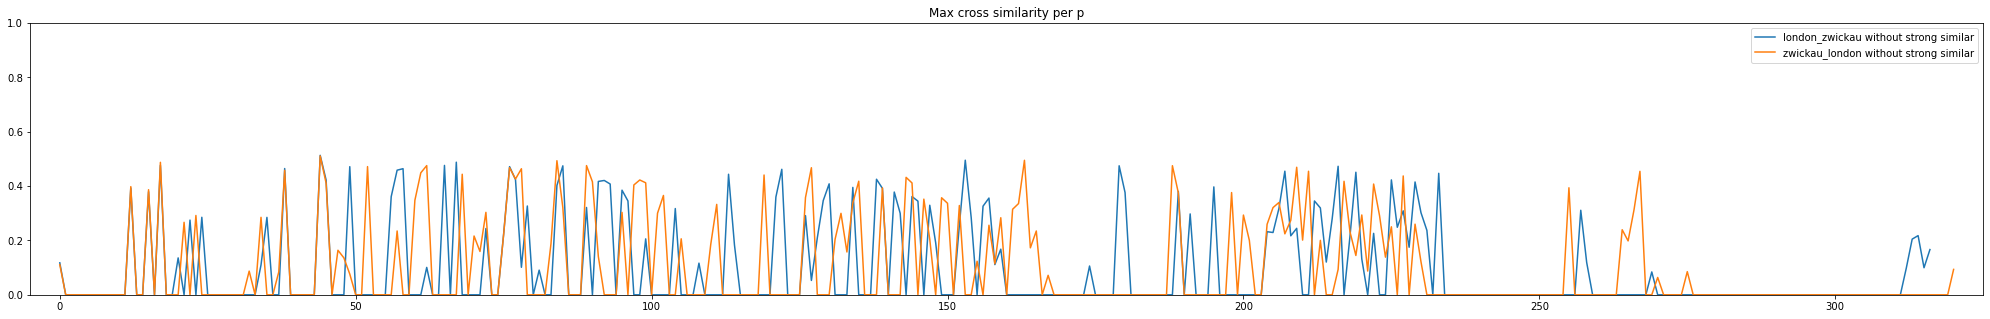

In [65]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot(london_mock, label="london_zwickau without strong similar")
ax.plot(zwickau_mock, label="zwickau_london without strong similar")

ax.set_ylim([0,1])
ax.set_xlim([-5,325])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [66]:
for i, p in enumerate(london_mock):
    print(f'{i} - {p}')

0 - 0.11764388949664854
1 - 0
2 - 0
3 - 0
4 - 0
5 - 0
6 - 0
7 - 0
8 - 0
9 - 0
10 - 0
11 - 0
12 - 0.39284623903832555
13 - 0
14 - 0
15 - 0.3795614775823583
16 - 0
17 - 0.4761944356269211
18 - 0
19 - 0
20 - 0.13573489960586135
21 - 0
22 - 0.2748500021130789
23 - 0
24 - 0.2851636430418756
25 - 0
26 - 0
27 - 0
28 - 0
29 - 0
30 - 0
31 - 0
32 - 0
33 - 0
34 - 0.10958967827181051
35 - 0.28483484882611376
36 - 0
37 - 0
38 - 0.46451913360624947
39 - 0
40 - 0
41 - 0
42 - 0
43 - 0
44 - 0.5131965887348493
45 - 0.4222422806614171
46 - 0
47 - 0
48 - 0
49 - 0.47140109488130083
50 - 0
51 - 0
52 - 0
53 - 0
54 - 0
55 - 0
56 - 0.36119973854904724
57 - 0.4584998172794402
58 - 0.4639573305415872
59 - 0
60 - 0
61 - 0
62 - 0.10078346116771511
63 - 0
64 - 0
65 - 0.47603894097286137
66 - 0
67 - 0.4879160842265339
68 - 0
69 - 0
70 - 0
71 - 0
72 - 0.2438555748979637
73 - 0
74 - 0
75 - 0.22429334438006254
76 - 0.47149779078804455
77 - 0.42397594122403226
78 - 0.10119151297836139
79 - 0.3267150136223708
80 - 0
81 -

In [67]:
london_mock

[0.11764388949664854,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.39284623903832555,
 0,
 0,
 0.3795614775823583,
 0,
 0.4761944356269211,
 0,
 0,
 0.13573489960586135,
 0,
 0.2748500021130789,
 0,
 0.2851636430418756,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.10958967827181051,
 0.28483484882611376,
 0,
 0,
 0.46451913360624947,
 0,
 0,
 0,
 0,
 0,
 0.5131965887348493,
 0.4222422806614171,
 0,
 0,
 0,
 0.47140109488130083,
 0,
 0,
 0,
 0,
 0,
 0,
 0.36119973854904724,
 0.4584998172794402,
 0.4639573305415872,
 0,
 0,
 0,
 0.10078346116771511,
 0,
 0,
 0.47603894097286137,
 0,
 0.4879160842265339,
 0,
 0,
 0,
 0,
 0.2438555748979637,
 0,
 0,
 0.22429334438006254,
 0.47149779078804455,
 0.42397594122403226,
 0.10119151297836139,
 0.3267150136223708,
 0,
 0.0907503296784504,
 0,
 0,
 0.4023123268415552,
 0.4745029565650809,
 0,
 0,
 0,
 0.32129528081646397,
 0,
 0.41710133331432486,
 0.42065609114437874,
 0.4075319033472222,
 0,
 0.3849044944504242,
 0.3453276553465425,
 0,
 0,
 0.205756

In [68]:
london_mock[44]

0.5131965887348493

In [69]:
london_zwickau_best_match_by_p_map[thesisDataReader.get_london_by_new_line()[44]]

{'original': {'index': 44,
  'best_match': {'5_gram': [44, 0.49755878325194636]}},
 'without_strong_similar': {'index': 10,
  'best_match': {'5_gram': (10, 0.5131965887348493)}}}

In [70]:
zwickau_london_best_match_by_p_map[thesisDataReader.get_zwickau_by_new_line()[44]]

{'original': {'index': 44, 'best_match': {'5_gram': [44, 0.4961417314966214]}},
 'without_strong_similar': {'index': 10,
  'best_match': {'5_gram': (10, 0.5108499922646857)}}}

#### strongly / poorly similar

In [71]:
london_zwickau_strongly_similar_indexes = [i for i, p in enumerate(london_mock) if p == 0]
london_zwickau_poorly_similar_indexes = [i for i, p in enumerate(london_mock) if p > 0]

In [72]:
print(len(london_zwickau_strongly_similar_indexes))
print(len(london_zwickau_poorly_similar_indexes))

218
99


In [73]:
london_zwickau_strongly_similar_corpus = [p for i, p in enumerate(thesisDataReader.get_london_by_new_line()) if i in set(london_zwickau_strongly_similar_indexes)]
london_zwickau_poorly_similar_corpus = [p for i, p in enumerate(thesisDataReader.get_london_by_new_line()) if i in set(london_zwickau_poorly_similar_indexes)]

In [74]:
len(london_zwickau_poorly_similar_corpus)

99

In [75]:
zwickau_london_strongly_similar_indexes = [i for i, p in enumerate(zwickau_mock) if p == 0]
zwickau_london_poorly_similar_indexes = [i for i, p in enumerate(zwickau_mock) if p > 0]

In [76]:
print(len(zwickau_london_strongly_similar_indexes))
print(len(zwickau_london_poorly_similar_indexes))

217
104


In [77]:
zwickau_london_strongly_similar_corpus = [p for i, p in enumerate(thesisDataReader.get_zwickau_by_new_line()) if i in set(zwickau_london_strongly_similar_indexes)]
zwickau_london_poorly_similar_corpus = [p for i, p in enumerate(thesisDataReader.get_zwickau_by_new_line()) if i in set(zwickau_london_poorly_similar_indexes)]

In [78]:
london_zwickau_strongly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_zwickau_strongly_similar_corpus,
    zwickau_london_strongly_similar_corpus,
)

In [79]:
zwickau_london_strongly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_london_strongly_similar_corpus,
    london_zwickau_strongly_similar_corpus,
)

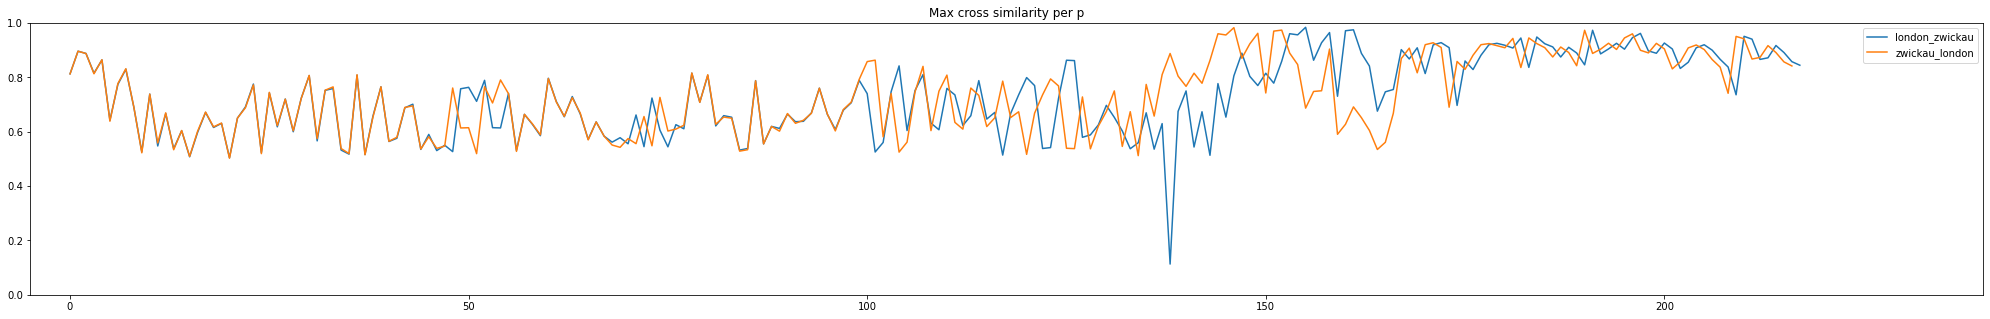

In [80]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot([i['5_gram'][1] for i in london_zwickau_strongly_similar_best_similarities], label="london_zwickau")
ax.plot([i['5_gram'][1] for i in zwickau_london_strongly_similar_best_similarities], label="zwickau_london")

ax.set_ylim([0,1])
ax.set_xlim([-5,240])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [81]:
london_zwickau_poorly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_zwickau_poorly_similar_corpus,
    zwickau_london_poorly_similar_corpus,
)

In [82]:
zwickau_london_poorly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_london_poorly_similar_corpus,
    london_zwickau_poorly_similar_corpus,
)

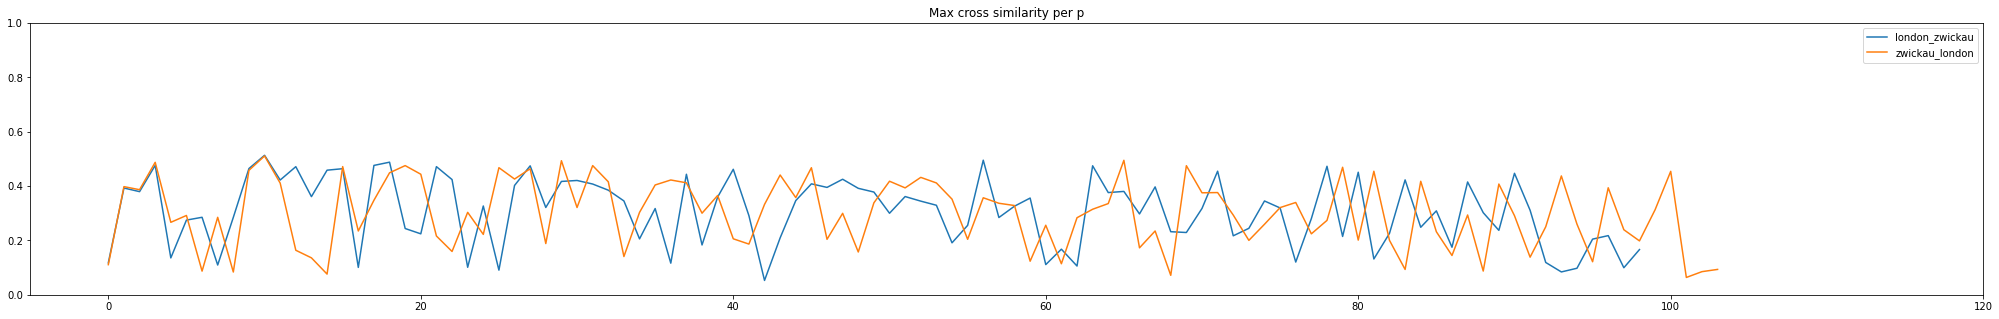

In [83]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot([i['5_gram'][1] for i in london_zwickau_poorly_similar_best_similarities], label="london_zwickau")
ax.plot([i['5_gram'][1] for i in zwickau_london_poorly_similar_best_similarities], label="zwickau_london")

ax.set_ylim([0,1])
ax.set_xlim([-5,120])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [84]:
london_breslau_strongly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_zwickau_strongly_similar_corpus,
    thesisDataReader.get_breslau_by_new_line(),
)
london_breslau_poorly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    london_zwickau_poorly_similar_corpus,
    thesisDataReader.get_breslau_by_new_line(),
)

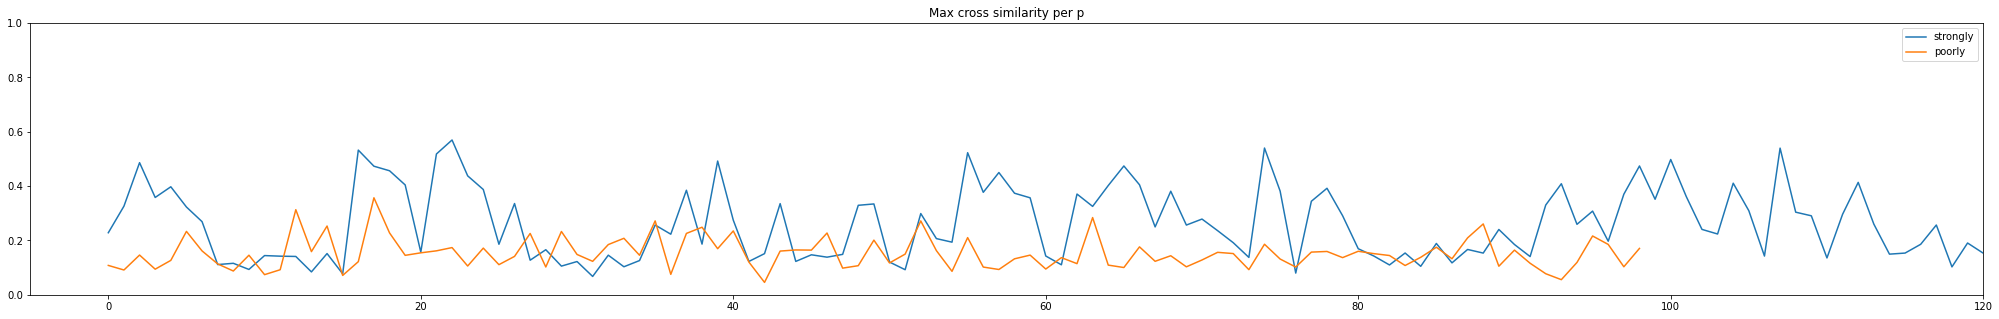

In [85]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot([i['5_gram'][1] for i in london_breslau_strongly_similar_best_similarities], label="strongly")
ax.plot([i['5_gram'][1] for i in london_breslau_poorly_similar_best_similarities], label="poorly")

ax.set_ylim([0,1])
ax.set_xlim([-5,120])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

In [86]:
zwickau_breslau_strongly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_london_strongly_similar_corpus,
    thesisDataReader.get_breslau_by_new_line(),
)
zwickau_breslau_poorly_similar_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
    zwickau_london_poorly_similar_corpus,
    thesisDataReader.get_breslau_by_new_line(),
)

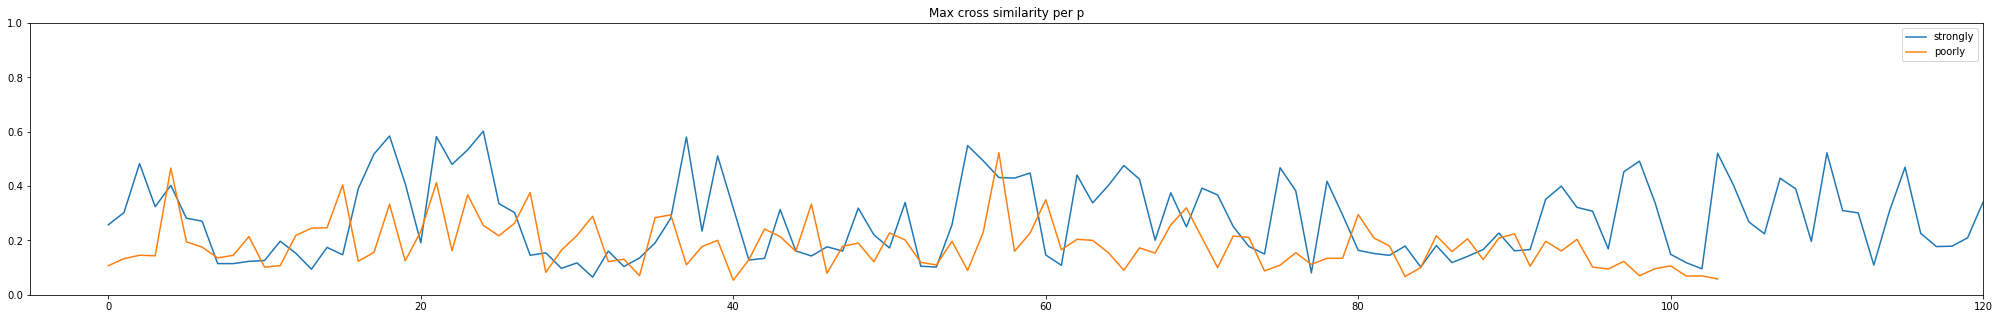

In [87]:
fig, ax = plt.subplots(figsize=(35, 5))

ax.plot([i['5_gram'][1] for i in zwickau_breslau_strongly_similar_best_similarities], label="strongly")
ax.plot([i['5_gram'][1] for i in zwickau_breslau_poorly_similar_best_similarities], label="poorly")

ax.set_ylim([0,1])
ax.set_xlim([-5,120])
ax.legend()
plt.title('Max cross similarity per p')
plt.show()

#### p aligment

In [88]:
london_zwickau_breslau_strongly_similar_p_aligment_df = thesisPAligment.create_london_p_aligment(
    london_zwickau_strongly_similar_corpus,
    zwickau_london_strongly_similar_corpus,
    london_zwickau_strongly_similar_best_similarities,
    thesisDataReader.get_breslau_by_new_line(),
    london_breslau_strongly_similar_best_similarities,
)

In [89]:
london_zwickau_breslau_strongly_similar_p_aligment_df

,london text,zwickau text,zwickau p#,zwickau score,breslau text,breslau p#,breslau score
0,cum in ueteribus historiis legamus sicut dicit...,cum sicut dicit ieronimus quosdam inueniamus l...,0,0.812947,uenerabantur quondam iudei sancta sanctorum qu...,1,0.228345
1,quis cristianus hiis uisis non festinet uenire...,quis cristianus hiis uisis non festinabit ueni...,1,0.896212,uenerabantur quondam iudei sancta sanctorum qu...,1,0.326126
2,redeat post hec in ierusalem ut uideat et audi...,redeat post in ierusalem uideat et audiat in t...,2,0.887962,uenerabantur quondam iudei sancta sanctorum qu...,1,0.486159
3,sunt preterea quedam que in locis ilis deuotio...,sunt preterea quedam que in locis ilis deuotio...,3,0.815394,sunt preterea que deuotionem excitant ampliore...,2,0.358153
4,eia domine deus uideo secundum ueteres histori...,eia domine deus uideo secundum ueteres histori...,4,0.864038,sunt preterea que deuotionem excitant ampliore...,2,0.397394
...,...,...,...,...,...,...,...
213,de lippari nauigantes per miliaria uenimus in ...,de lippari nauigantes per miliaria uenimus in ...,212,0.871923,sunt preterea que deuotionem excitant ampliore...,2,0.120797
214,de strongoli igitur mouentes auta et sperantes...,de strongoli igitur mouentes auta et sperantes...,213,0.917238,procedendo igitur de accon per primam diuisioe...,24,0.078676
215,egressi itaque de galea uenimus boias de quo l...,egressi itaque de galea uenimus baias de quo l...,214,0.891483,regia erat hec ciuitas in monte pulcra nimis u...,40,0.134890
216,in neapoli in castro saluatoris uidi ouum uirg...,in neapoli in castro saluatoris uidi ouum uirg...,215,0.857767,uenerabantur quondam iudei sancta sanctorum qu...,1,0.110843


In [90]:
london_zwickau_breslau_strongly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/strongly_similar/london_zwickau_breslau.csv')

In [91]:
zwickau_london_strongly_similar_corpus

['cum sicut dicit ieronimus quosdam inueniamus lustrasse prouintias maria transfretasse ut ea que ex scripturis nouerant coram uiderent ut plato mempiticos uates et egiptum appolonius qui persas intrauit transiuit cancasum albanos sticas massagetas quoque ut iarcam uideret et tandem egiptum intrauit ut famosam mensam solis uideret in sabulo quid mirum si cristiani terram ilam quam cristi sonant ecclesie uniuerse uidere et uisitare desiderant uenerabantur antiqui sancta sanctorum quia ibi erat arca testamenti et cernibulum cum propitiatorio et manna et uirga aaron que fronduerat que omnia erant umbra nonne uenerabilius est apud nos sepulcrum dulcis iesu quod quotiens quis ingreditur totiens inuolutum sindone mentis oculis uidet saluatorem et paululum procedens uidet lapidem reuolutum angelum in eo sedentem et sudarium cum lintiaminibus mulieribus ostendentem',
 'quis cristianus hiis uisis non festinabit uenire in betleem contemplans puerum in presepio uagientem mariam in diuersorio sub 

In [92]:
zwickau_london_breslau_strongly_similar_p_aligment_df = thesisPAligment.create_zwickau_p_aligment(
    zwickau_london_strongly_similar_corpus,
    london_zwickau_strongly_similar_corpus,
    zwickau_london_strongly_similar_best_similarities,
    thesisDataReader.get_breslau_by_new_line(),
    zwickau_breslau_strongly_similar_best_similarities,
)

In [93]:
zwickau_london_breslau_strongly_similar_p_aligment_df

,zwickau text,london text,london p#,london score,breslau text,breslau p#,breslau score
0,cum sicut dicit ieronimus quosdam inueniamus l...,cum in ueteribus historiis legamus sicut dicit...,0,0.812969,uenerabantur quondam iudei sancta sanctorum qu...,1,0.257571
1,quis cristianus hiis uisis non festinabit ueni...,quis cristianus hiis uisis non festinet uenire...,1,0.896252,uenerabantur quondam iudei sancta sanctorum qu...,1,0.302364
2,redeat post in ierusalem uideat et audiat in t...,redeat post hec in ierusalem ut uideat et audi...,2,0.887686,uenerabantur quondam iudei sancta sanctorum qu...,1,0.482685
3,sunt preterea quedam que in locis ilis deuotio...,sunt preterea quedam que in locis ilis deuotio...,3,0.813261,sunt preterea que deuotionem excitant ampliore...,2,0.324151
4,eia domine deus uideo secundum ueteres histori...,eia domine deus uideo secundum ueteres histori...,4,0.864815,sunt preterea que deuotionem excitant ampliore...,2,0.402661
...,...,...,...,...,...,...,...
212,de lippari nauigantes per miliaria uenimus in ...,de lippari nauigantes per miliaria uenimus in ...,213,0.873394,sunt preterea que deuotionem excitant ampliore...,2,0.125484
213,de strongoli igitur mouentes auta et sperantes...,de strongoli igitur mouentes auta et sperantes...,214,0.916748,procedendo igitur de accon per primam diuisioe...,24,0.069664
214,egressi itaque de galea uenimus baias de quo l...,egressi itaque de galea uenimus boias de quo l...,215,0.891232,regia erat hec ciuitas in monte pulcra nimis u...,40,0.140348
215,in neapoli in castro saluatoris uidi ouum uirg...,in neapoli in castro saluatoris uidi ouum uirg...,216,0.857048,regia erat hec ciuitas in monte pulcra nimis u...,40,0.100498


In [94]:
zwickau_london_breslau_strongly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/strongly_similar/zwickau_london_breslau.csv')

In [95]:
breslau_london_zwickau_strongly_similar_p_aligment_df = thesisPAligment.create_breslau_p_aligment(
    thesisDataReader.get_breslau_by_new_line(),
    zwickau_london_strongly_similar_corpus,
    thesisCosineSimilarities.get_cross_version_best_similarities(
        thesisDataReader.get_breslau_by_new_line(),
        zwickau_london_strongly_similar_corpus
    ),
    london_zwickau_strongly_similar_corpus,
    thesisCosineSimilarities.get_cross_version_best_similarities(
        thesisDataReader.get_breslau_by_new_line(),
        london_zwickau_strongly_similar_corpus
    ),
)

In [96]:
breslau_london_zwickau_strongly_similar_p_aligment_df

,breslau text,zwickau text,zwickau p#,zwickau score,london text,london p#,london score
0,dilectissimo in cristo iesu patri burghardo le...,uerum ego frater burcardus ordinis fratrum pre...,5,0.123907,eia domine deus uideo secundum ueteres histori...,4,0.112346
1,uenerabantur quondam iudei sancta sanctorum qu...,redeat post in ierusalem uideat et audiat in t...,2,0.495607,redeat post hec in ierusalem ut uideat et audi...,2,0.498945
2,sunt preterea que deuotionem excitant ampliore...,eia domine deus uideo secundum ueteres histori...,4,0.408953,eia domine deus uideo secundum ueteres histori...,4,0.409043
3,suscipite ergo gratanter laborem meum quem lib...,sciendum autem quod in rei ueritate licet quid...,179,0.059689,de multitudine cristianorum sciendum autem quo...,180,0.059762
4,primo ergo descriptionis inicium ciuitate aggr...,de diuisione quarte septentrionalis primum igi...,16,0.394195,primum igitur descriptionis inicium sumitur a ...,16,0.539455
...,...,...,...,...,...,...,...
66,quinta erat porta sterquilinii a superiori con...,porta sterquilini quinta porta erat ab ista co...,163,0.423693,quinta porta erat contra austrum ab ista et di...,132,0.476084
67,sexta erat porta ualis quia ducebat et ducit h...,porta gregis sexta porta erat ab ista similite...,164,0.523001,sexta porta erat ab ista similiter contra aust...,133,0.353445
68,septima est porta aurea hec est australis hec ...,porta aurea septima dicebatur porta aurea et e...,165,0.475237,septima porta erat ab ista similiter contra au...,134,0.439978
69,octaua erat porta aquarum quia per eam aque im...,porta fontis octaua est inter montem sion et m...,166,0.468176,octaua porta fuit a superiore similiter austra...,135,0.477701


In [97]:
breslau_london_zwickau_strongly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/strongly_similar/breslau_london_zwickau.csv')

In [98]:
london_zwickau_breslau_poorly_similar_p_aligment_df = thesisPAligment.create_london_p_aligment(
    london_zwickau_poorly_similar_corpus,
    zwickau_london_poorly_similar_corpus,
    london_zwickau_poorly_similar_best_similarities,
    thesisDataReader.get_breslau_by_new_line(),
    london_breslau_poorly_similar_best_similarities,
)

In [99]:
london_zwickau_breslau_poorly_similar_p_aligment_df

,london text,zwickau text,zwickau p#,zwickau score,breslau text,breslau p#,breslau score
0,liber de terra sancta,de betleem ad leucam contra occidentem est bes...,84,0.117644,primo ergo descriptionis inicium ciuitate aggr...,4,0.108086
1,quarta est siria damasci in qua est damascus c...,quarta est siria damasci in qua est damascus c...,1,0.392846,iuxta hanc est fons ortorum fluens impetu de l...,16,0.091248
2,tertia est cuius metropolis est betsan sita su...,tertia est cuius metropolis est betsan sita su...,2,0.379561,de suna quatuor leucas fere contra iordanem li...,35,0.146229
3,secunda cuius metropolis est petra ciuitas oli...,secunda est cuius metropolis est rabac ciuitas...,3,0.476194,de galgalis ad dimidiam leucam mons quarentene...,43,0.094276
4,prima diuisio terre sancte sciendum igitur pri...,traconitidis ultra iordanem uero tota terra qu...,21,0.135735,sequitur de prima parte diuisionis australis h...,62,0.126641
...,...,...,...,...,...,...,...
94,de luca iterum redii romam et de roma ueni alb...,magdalum inde leucis contra meridiem magdalum ...,26,0.097684,sunt preterea que deuotionem excitant ampliore...,2,0.119034
95,diuisio terre tribuum terram tribuum citra ior...,conualis ilustris siue ualis que uocatur ailon...,41,0.204864,ad pedem eiusdem montis penitia uero regio ext...,5,0.216380
96,tribus sabulon carmelum prope caimont usque ge...,traconitidis ultra iordanem uero tota terra qu...,21,0.217729,ad pedem eiusdem montis penitia uero regio ext...,5,0.185316
97,tribus dan loca conualis iuxta mare magnum ad ...,conualis ilustris siue ualis que uocatur ailon...,41,0.099561,sequitur de prima parte diuisionis australis h...,62,0.103158


In [100]:
london_zwickau_breslau_poorly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/poorly_similar/london_zwickau_breslau.csv')

In [101]:
zwickau_london_breslau_poorly_similar_p_aligment_df = thesisPAligment.create_zwickau_p_aligment(
    zwickau_london_poorly_similar_corpus,
    london_zwickau_poorly_similar_corpus,
    zwickau_london_poorly_similar_best_similarities,
    thesisDataReader.get_breslau_by_new_line(),
    zwickau_breslau_poorly_similar_best_similarities,
)

In [102]:
zwickau_london_breslau_poorly_similar_p_aligment_df

,zwickau text,london text,london p#,london score,breslau text,breslau p#,breslau score
0,incipit descriptio terre sancte,longitudo et latitudo tocius terre sancta secu...,98,0.110907,primo ergo descriptionis inicium ciuitate aggr...,4,0.107087
1,quarta est siria damasci in qua est damascus c...,quarta est siria damasci in qua est damascus c...,1,0.397964,sunt preterea que deuotionem excitant ampliore...,2,0.132804
2,tertia est cuius metropolis est betsan sita su...,tertia est cuius metropolis est betsan sita su...,2,0.386681,de suna quatuor leucas fere contra iordanem li...,35,0.145449
3,secunda est cuius metropolis est rabac ciuitas...,secunda cuius metropolis est petra ciuitas oli...,3,0.487403,est autem tota terra ista a ciuitate bosra usq...,27,0.143503
4,de penicea regione penicea uero regio adhuc ul...,penitia uero regio siue siria penicis adhuc ex...,5,0.266694,ad pedem eiusdem montis penitia uero regio ext...,5,0.466135
...,...,...,...,...,...,...,...
99,ab ilo inter austrum et occidentem situs ager ...,inter orientem uero et austrum respectum ciuit...,70,0.312941,ibi uidi celam beati ieronimi lectum eius et s...,61,0.096244
100,post hec sequitur mons gion ab occidente super...,iste mons gion ab occidente supereminet ciuita...,71,0.454225,ab ista uoragine longe infra turrim dauid cont...,52,0.106338
101,uerum est autem quod in terra ipsa non inueniu...,et nota quod ista quarta diuisio non habet uil...,23,0.063850,nec est uerum quod ducitur de monte gelboe quo...,38,0.068726
102,sed cultores non dico fortissimos sed pessimos...,inde ad dimidiam leucam ad sinistram supra uia...,40,0.085158,de fontibus ilis ad unam leucam modicam est ci...,8,0.069734


In [103]:
zwickau_london_breslau_poorly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/poorly_similar/zwickau_london_breslau.csv')

In [104]:
breslau_london_zwickau_poorly_similar_p_aligment_df = thesisPAligment.create_breslau_p_aligment(
    thesisDataReader.get_breslau_by_new_line(),
    zwickau_london_poorly_similar_corpus,
    thesisCosineSimilarities.get_cross_version_best_similarities(
        thesisDataReader.get_breslau_by_new_line(),
        zwickau_london_poorly_similar_corpus
    ),
    london_zwickau_poorly_similar_corpus,
    thesisCosineSimilarities.get_cross_version_best_similarities(
        thesisDataReader.get_breslau_by_new_line(),
        london_zwickau_poorly_similar_corpus
    ),
)

In [105]:
breslau_london_zwickau_poorly_similar_p_aligment_df

,breslau text,zwickau text,zwickau p#,zwickau score,london text,london p#,london score
0,dilectissimo in cristo iesu patri burghardo le...,sed quia que in ea facta sunt uniuerse cristi ...,68,0.144901,de seporo ad leucas contra austrum fere sed mo...,30,0.087690
1,uenerabantur quondam iudei sancta sanctorum qu...,betlehem de ierusalem leucis contra austrum si...,80,0.108614,sed obmissis omnibus ad ierusalem quantocius u...,61,0.107724
2,sunt preterea que deuotionem excitant ampliore...,quarta est siria damasci in qua est damascus c...,1,0.147491,de luca iterum redii romam et de roma ueni alb...,94,0.130427
3,suscipite ergo gratanter laborem meum quem lib...,in parte arabie dicitur esse segor ciuitas ubi...,57,0.039396,montes autem circa ierusalem erant isti ab ori...,68,0.046424
4,primo ergo descriptionis inicium ciuitate aggr...,incipit descriptio terre sancte,0,0.111363,liber de terra sancta,0,0.116613
...,...,...,...,...,...,...,...
66,quinta erat porta sterquilinii a superiori con...,huic ad austrum adiungitur desertum maon et mo...,89,0.122606,de betel leucis de ierusalem non longe a rama ...,55,0.171984
67,sexta erat porta ualis quia ducebat et ducit h...,betfage de betania modico interualo in uale in...,66,0.094869,ante oscium occidentale huius ecclesie foris e...,66,0.102966
68,septima est porta aurea hec est australis hec ...,de montibus montes autem circa ierusalem sicut...,97,0.087338,iste mons gion ab occidente supereminet ciuita...,71,0.076542
69,octaua erat porta aquarum quia per eam aque im...,fons siloe inde contra locum istum directe ult...,69,0.193686,sub monte sion contra regiam salomonis in occi...,63,0.176063


In [106]:
breslau_london_zwickau_poorly_similar_p_aligment_df.to_csv('../computed_data/p_aligment/by_new_line/poorly_similar/breslau_london_zwickau.csv')

In [107]:
# london_breslau_best_match_by_p_map = create_best_match_by_text_map(
#     thesisDataReader.get_london_by_new_line(),
#     london_breslau_original_best_similarities,
#     london_corpus_without_strong_similar,
#     london_breslau_full_remove_best_similarities,
# )

In [108]:
# len(zwickau_london_full_remove_best_similarities)

In [109]:
# london_breslau_mock = []

# for index, text in enumerate(thesisDataReader.get_london_by_new_line()):
#     text_info = london_breslau_best_match_by_p_map[text]
#     similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
#     london_breslau_mock.append(similarity_score)

In [110]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot([i['5_gram'][1] for i in london_breslau_original_best_similarities], label="london_breslau original")
# # ax.plot([i['5_gram'][1] for i in london_breslau_full_remove_best_similarities], label="london_breslau without strong similar")
# ax.plot(london_breslau_mock, label="london_breslau without strong similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,320])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [111]:
# zwickau_mock = []

# for index, text in enumerate(thesisDataReader.get_zwickau_by_new_line()):
#     text_info = zwickau_london_best_match_by_p_map[text]
#     similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
#     zwickau_mock.append(similarity_score)

In [112]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot([i['5_gram'][1] for i in zwickau_london_original_best_similarities], label="zwickau_london original")
# ax.plot(zwickau_mock, label="zwickau_london without strong similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [113]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot(london_mock, label="london_zwickau without strong similar")
# ax.plot(zwickau_mock, label="zwickau_london without strong similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [114]:
# related = []
# for i, p in enumerate(london_mock):
#     if p > 0:
#         london_p_info = london_zwickau_best_match_by_p_map[thesisDataReader.get_london_by_new_line()[i]]
#         london_p_info_original = london_p_info['original']
#         london_p_info_original_best_match_p = london_p_info_original['best_match']['5_gram'][0]
        
#         zwickau_p_info = zwickau_london_best_match_by_p_map[thesisDataReader.get_zwickau_by_new_line()[london_p_info_original_best_match_p]]
#         zwickau_p_info_original = zwickau_p_info['original']
#         zwickau_p_info_original_best_match_p = zwickau_p_info_original['best_match']['5_gram'][0]
        
#         if london_p_info_original_best_match_p == zwickau_p_info_original_best_match_p:
#             related.append(i)
# print(related)
# print(len(related))

In [115]:
# related = []
# # for i, p in enumerate(london_mock):
# #     if p > 0:
# #         london_p_info = london_zwickau_best_match_by_p_map[thesisDataReader.get_london_by_new_line()[i]]
# #         london_p_info_original = london_p_info['original']
# #         london_p_info_original_best_match_p = london_p_info_original['best_match']['5_gram'][0]
# #         london_p_info_original_best_match_score = london_p_info_original['best_match']['5_gram'][1]
        
# #         zwickau_p_info = zwickau_london_best_match_by_p_map[thesisDataReader.get_zwickau_by_new_line()[london_p_info_original_best_match_p]]
# #         zwickau_p_info_original = zwickau_p_info['original']
# #         zwickau_p_info_original_best_match_p = zwickau_p_info_original['best_match']['5_gram'][0]
# #         zwickau_p_info_original_best_match_score = zwickau_p_info_original['best_match']['5_gram'][1]
        
# #         if london_p_info_original_best_match_p == zwickau_p_info_original_best_match_p and (zwickau_p_info_original_best_match_score > 0.5 and london_p_info_original_best_match_score > 0.5):
# #             related.append(i)
# #             print('london_p_info_original_best_match_score', london_p_info_original_best_match_score)
# #             print('zwickau_p_info_original_best_match_score', zwickau_p_info_original_best_match_score)
# print(related)
# print(len(related))

In [116]:
# london_zwickau_best_match_by_p_map[thesisDataReader.get_london_by_new_line()[22]]

In [117]:
# zwickau_london_best_match_by_p_map[thesisDataReader.get_zwickau_by_new_line()[11]]

In [118]:
# london_zwickau_strongly_similar_p = [i for i, p in enumerate(london_mock) if p == 0]
# london_zwickau_poorly_similar_p = [i for i, p in enumerate(london_mock) if p > 0]
# print('strongly similar amount',len(london_zwickau_strongly_similar_p))
# print('poorly similar amount', len(london_zwickau_poorly_similar_p))

In [119]:
# zwickau_london_strongly_similar_p = [i for i, p in enumerate(zwickau_mock) if p == 0]
# zwickau_london_poorly_similar_p = [i for i, p in enumerate(zwickau_mock) if p > 0]
# print('strongly similar amount',len(zwickau_london_strongly_similar_p))
# print('poorly similar amount', len(zwickau_london_poorly_similar_p))

In [120]:
# zwickau_breslau_original_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     thesisDataReader.get_zwickau_by_new_line(),
#     thesisDataReader.get_breslau_by_new_line(),
# )

In [121]:
# zwickau_breslau_full_remove_best_similarities = thesisCosineSimilarities.get_cross_version_best_similarities(
#     zwickau_corpus_without_strong_similar,
#     thesisDataReader.get_breslau_by_new_line(),
# )

In [122]:
# zwickau_breslau_best_match_by_p_map = create_best_match_by_text_map(
#     thesisDataReader.get_zwickau_by_new_line(),
#     zwickau_breslau_original_best_similarities,
#     zwickau_corpus_without_strong_similar,
#     zwickau_breslau_full_remove_best_similarities,
# )

In [123]:
# zwickau_breslau_mock = []

# for index, text in enumerate(thesisDataReader.get_zwickau_by_new_line()):
#     text_info = zwickau_breslau_best_match_by_p_map[text]
#     similarity_score = 0 if text_info.get('without_strong_similar') is None else text_info['without_strong_similar']['best_match']['5_gram'][1]
#     zwickau_breslau_mock.append(similarity_score)

In [124]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot([i['5_gram'][1] for i in zwickau_breslau_original_best_similarities], label="zwickau_breslau original")
# # ax.plot([i['5_gram'][1] for i in london_breslau_full_remove_best_similarities], label="london_breslau without strong similar")
# ax.plot(zwickau_breslau_mock, label="zwickau_breslau without strong similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [125]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot([i['5_gram'][1] for i in zwickau_breslau_original_best_similarities], label="zwickau_breslau original")
# ax.plot([i['5_gram'][1] for i in london_breslau_original_best_similarities], label="london_breslau original")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

In [126]:
# fig, ax = plt.subplots(figsize=(35, 5))

# ax.plot(zwickau_breslau_mock, label="zwickau_breslau without most similart")
# ax.plot(london_breslau_mock, label="london_breslau without most similar")

# ax.set_ylim([0,1])
# ax.set_xlim([-5,325])
# ax.legend()
# plt.title('Max cross similarity per p')
# plt.show()

# Create poorly similar corpus with chops

In [242]:
london_poorly_similar_corpus_with_gaps = [p if london_mock[i] > 0 else None for i, p in enumerate(thesisDataReader.get_london_by_new_line())]
zwickau_poorly_similar_corpus_with_gaps = [p if zwickau_mock[i] > 0 else None for i, p in enumerate(thesisDataReader.get_zwickau_by_new_line())]

In [243]:
np.save(
    '../computed_data/corpus/london/london_poorly_similar_corpus_with_gaps.npy',
    np.array(london_poorly_similar_corpus_with_gaps)
)
np.save(
    '../computed_data/corpus/zwickau/zwickau_poorly_similar_corpus_with_gaps.npy',
    np.array(zwickau_poorly_similar_corpus_with_gaps)
)

In [244]:
london_zwickau_breslau_p_aligment = pd.read_csv('../computed_data/p_aligment/by_new_line/london_zwickau_breslau.csv').drop(['Unnamed: 0'], axis=1)
zwickau_london_breslau_p_aligment = pd.read_csv('../computed_data/p_aligment/by_new_line/zwickau_london_breslau.csv').drop(['Unnamed: 0'], axis=1)

In [245]:
london_zwickau_breslau_p_aligment

,london text,zwickau text,zwickau p#,zwickau score,breslau text,breslau p#,breslau score
0,liber de terra sancta,de betleem ad leucam contra occidentem est bes...,217,0.095420,primo ergo descriptionis inicium ciuitate aggr...,4,0.108086
1,cum in ueteribus historiis legamus sicut dicit...,cum sicut dicit ieronimus quosdam inueniamus l...,1,0.813105,uenerabantur quondam iudei sancta sanctorum qu...,1,0.228345
2,quis cristianus hiis uisis non festinet uenire...,quis cristianus hiis uisis non festinabit ueni...,2,0.895885,uenerabantur quondam iudei sancta sanctorum qu...,1,0.326126
3,redeat post hec in ierusalem ut uideat et audi...,redeat post in ierusalem uideat et audiat in t...,3,0.890322,uenerabantur quondam iudei sancta sanctorum qu...,1,0.486159
4,sunt preterea quedam que in locis ilis deuotio...,sunt preterea quedam que in locis ilis deuotio...,4,0.816549,sunt preterea que deuotionem excitant ampliore...,2,0.358153
...,...,...,...,...,...,...,...
312,de luca iterum redii romam et de roma ueni alb...,multa alia uidi et perambulaui in terra ila qu...,296,0.190744,sunt preterea que deuotionem excitant ampliore...,2,0.119034
313,diuisio terre tribuum terram tribuum citra ior...,isti duo montes ita sunt dispositi ut gelboe s...,114,0.232923,ad pedem eiusdem montis penitia uero regio ext...,5,0.216380
314,tribus sabulon carmelum prope caimont usque ge...,isti duo montes ita sunt dispositi ut gelboe s...,114,0.220279,ad pedem eiusdem montis penitia uero regio ext...,5,0.185316
315,tribus dan loca conualis iuxta mare magnum ad ...,isti duo montes ita sunt dispositi ut gelboe s...,114,0.103594,sequitur de prima parte diuisionis australis h...,62,0.103158


In [246]:
p_aligment_with_chop_by_london_by_order = thesisPAligment.create_p_aligment_df_with_chop_by_london(london_zwickau_breslau_p_aligment).iloc[london_zwickau_strongly_similar_indexes]

In [247]:
p_aligment_with_chop_by_london_by_order

,london chop,zwickau chop,london text,zwickau text,zwickau p#,zwickau score,breslau text,breslau p#,breslau score
1,ueteribus historiis legamus beatus libris posi...,inueniamus scripturis mempiticos appolonius ca...,cum in ueteribus historiis legamus sicut dicit...,cum sicut dicit ieronimus quosdam inueniamus l...,1,0.813105,uenerabantur quondam iudei sancta sanctorum qu...,1,0.228345
2,festinet pacem hominibus maiestate,festinabit magestate,quis cristianus hiis uisis non festinet uenire...,quis cristianus hiis uisis non festinabit ueni...,2,0.895885,uenerabantur quondam iudei sancta sanctorum qu...,1,0.326126
3,defluentem iudicatum porta ciuitatis succenden...,fluentem iudicari succedentem plena extat exti...,redeat post hec in ierusalem ut uideat et audi...,redeat post in ierusalem uideat et audiat in t...,3,0.890322,uenerabantur quondam iudei sancta sanctorum qu...,1,0.486159
4,augent quot quot media nabenia maromea nestori...,augeant quod medea iabenia maronite nestoriari...,sunt preterea quedam que in locis ilis deuotio...,sunt preterea quedam que in locis ilis deuotio...,4,0.816549,sunt preterea que deuotionem excitant ampliore...,2,0.358153
5,domumque cognationem dereliquentem deserentem ...,domum congnationem suam derelinquentem deferen...,eia domine deus uideo secundum ueteres histori...,eia domine deus uideo secundum ueteres histori...,5,0.864300,sunt preterea que deuotionem excitant ampliore...,2,0.397394
...,...,...,...,...,...,...,...,...,...
307,strongoli duabus eo episcopi talanario ienuens...,strangoli sumitatem montis ipso tasanaxio ianu...,de lippari nauigantes per miliaria uenimus in ...,de lippari nauigantes per miliaria uenimus in ...,315,0.873119,sunt preterea que deuotionem excitant ampliore...,2,0.120797
308,paranoria ut alpiam,peranona dicta scariotis malpiam matei apostol...,de strongoli igitur mouentes auta et sperantes...,de strongoli igitur mouentes auta et sperantes...,316,0.917382,procedendo igitur de accon per primam diuisioe...,24,0.078676
309,boias secundum sicut maius fornicem triumpalem...,baias sed ile circundatur infinitis eorumdem n...,egressi itaque de galea uenimus boias de quo l...,egressi itaque de galea uenimus baias de quo l...,317,0.892637,regia erat hec ciuitas in monte pulcra nimis u...,40,0.134890
310,ciprianum ferentinum anagniam fortinum antonin...,queo quam sed sed ciparum felitinum anaginam f...,in neapoli in castro saluatoris uidi ouum uirg...,in neapoli in castro saluatoris uidi ouum uirg...,318,0.858228,uenerabantur quondam iudei sancta sanctorum qu...,1,0.110843


In [248]:
london_exceptional_corpus = [ p if p is not None else p_aligment_with_chop_by_london_by_order.loc[i]['london chop'] for i, p in enumerate(london_poorly_similar_corpus_with_gaps)]

In [249]:
zwickau_exceptional_corpus = [ p if p is not None else p_aligment_with_chop_by_london_by_order.loc[p_aligment_with_chop_by_order['zwickau p#'] == i]['zwickau chop'].values[0] for i, p in enumerate(zwickau_poorly_similar_corpus_with_gaps)]

In [250]:
with open("../computed_data/corpus/london/london_poorly_similar_with_chops.txt", "w") as text_file:
    text_file.write('\n'.join(london_exceptional_corpus))

In [262]:
np.save(
    '../computed_data/corpus/london/london_poorly_similar_with_chops.npy',
    np.array(london_exceptional_corpus)
)

In [257]:
with open("../computed_data/corpus/zwickau/zwickau_poorly_similar_with_chops.txt", "w") as text_file:
    text_file.write('\n'.join(zwickau_exceptional_corpus))

In [263]:
np.save(
    '../computed_data/corpus/zwickau/zwickau_poorly_similar_with_chops.npy',
    np.array(zwickau_exceptional_corpus)
)

In [251]:
london_exceptional_corpus[246]

''

In [252]:
len(thesisDataReader.get_london_by_new_line())

317

In [253]:
len(zwickau_exceptional_corpus)

321

In [254]:
len(thesisDataReader.get_zwickau_by_new_line())

321

In [255]:
p_aligment_with_chop_by_london_by_order.loc[246]

london chop                                                       
zwickau chop                                                   get
london text      inde ad leucas non longe a mari est get ciuita...
zwickau text     get inde ad leucas non longe a mari est get ci...
zwickau p#                                                     242
zwickau score                                             0.983732
breslau text     sequitur de prima parte diuisionis australis h...
breslau p#                                                      62
breslau score                                             0.219137
Name: 246, dtype: object

In [260]:
london_without_shared_words = 'get inde ad leucas non longe a mari est get ciuitas una de ciuitatibus pilistinorum que nunc ibilim dicitur et est modica ualde in cole sita'
word = 'get'
re.sub(r'\b' + word + r'\b', '', london_without_shared_words, count = 1).replace('  ', ' ').strip()

'inde ad leucas non longe a mari est get ciuitas una de ciuitatibus pilistinorum que nunc ibilim dicitur et est modica ualde in cole sita'

In [261]:
thesisDataReader.get_zwickau_by_new_line()[318]

'in neapoli in castro saluatoris uidi ouum uirgilii in piala uitrea queo os strictum habet sed fundum latum et amplum super quam est tabula lignea rotunda interius et super tabulam nidus quasi de graminibus et in eo est ouum minus ouo galine sed modico maius columbe sed pendet ad trabem per katenam ferream in neapoli steti diebus inde per auersam montem cassinum sanctum germanum aquinum ciparum felitinum anaginam montem fortunum ueni romam ubi primo uisitaui sanctum iohannem in laterano sanctam crucem sanctum sixtum sanctum iohannem ante latinam portam palacium antonii sanctum sebastianum in catacumbis domine quo uadis palacium uespesiani sanctum paulum piramidem remi s sabinam in monte auentino ubi stant fratres alexii palacium s mariam de niue s mariam maiorem s laurencium et s stefanum agnetem cum annulo constantiam filiam constancieni petrum ad uincula palacium diocletiani iohannem et paulum gregorium columpnam saxonum nimis mirabilem omnia gesta saxonum continentem s mariam rotund